# Energy-Efficient Wireless Sensor Network (EE-WSN) Simulation

This notebook compares 6 clustering algorithms for WSN energy optimization:
1. **RLHC_PROPOSED CEN** - Novel RL-driven hybrid clustering method
2. **RLHC_PROPOSED FED** - Novel RL-driven hybrid clustering method


## 1. Setup & Installation

In [1]:
# Install required packages (uncomment if needed)
# !pip install numpy matplotlib pandas scikit-fuzzy

import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import pandas as pd
import math
from collections import defaultdict
import skfuzzy as fuzz
from IPython.display import HTML
import matplotlib.animation as animation
from scipy.stats import rice, lognorm
from copy import deepcopy

print('All packages imported successfully!')

All packages imported successfully!


## 2. Configuration Constants

In [2]:
# Simulation Parameters
AREA_SIZE = 1000  # meters L, B
N_NODES = 150       # number of sensor nodes
INIT_ENERGY = 2.0   # joules per node
NUM_CLUSTERS = int(N_NODES * 0.1)
ROUNDS = 4000
PACKET_SIZE_BYTES = 128
PACKET_SIZE_BITS = PACKET_SIZE_BYTES * 8
N_HALF = N_NODES // 2
SEED = 10  #10
SECTOR_ROWS = 3
SECTOR_COLS = 3
BASE_STATION_FIXED = (AREA_SIZE / 2, AREA_SIZE / 2)
BS_TRAJECTORY = []

# RLHC in Centralized and Federated
M_RLHC_CEN = "RLHC_PROPOSED_CEN"
M_RLHC_FED = "RLHC_PROPOSED_FED"

# Routing Parameters
GLOBAL_ROUTING_INFO = {}

GLOBAL_ROUTING_INFO[M_RLHC_CEN] = {}
GLOBAL_ROUTING_INFO[M_RLHC_FED] = {}

GLOBAL_ROUTING_INFO[M_RLHC_CEN].setdefault("nodes_pos", {})
GLOBAL_ROUTING_INFO[M_RLHC_FED].setdefault("nodes_pos", {})

# Node Mobility
NODE_MOBILITY_ENABLED = True
SPEED_MAX = 1


# Base/Sink Mobility
BS_MODE = "fixed"   # fixed, mobile_circle, mobile_random

if BS_MODE == "mobile_circle":
    ROUNDS = 500
    EFFECTIVE_ROUNDS = 275  # BS Complete one circle in these many rounds
elif BS_MODE == "mobile_random":
    ROUNDS = 150


# Radio Energy Model (First-order)
E_ELEC = 50e-9  # J/bit (typical)
EPS_FS = 10e-12  # J/bit/m^2 (free space)
EPS_MP = 0.0013e-12  # J/bit/m^4 (multipath)
D0 = math.sqrt(EPS_FS / EPS_MP) if EPS_MP > 0 else 87.7  # threshold
SUCCESS_TX_RX = 0

# Channel Model Constants
PATH_LOSS_EXPONENT = 2.16          # LOS underground tunnel
SHADOWING_STD_DEV_DB = 5.0         # Log-normal shadowing (dB)
RICIAN_K_FACTOR_DB = 6.0           # Rician K-factor (dB)
RICIAN_K_FACTOR_LIN = 10**(RICIAN_K_FACTOR_DB / 10.0)
NOISE_POWER_DBM = -95.0           # Thermal noise power (dBm)
TX_POWER_DBM = 0.0                 # Transmit power (dBm)
OPERATING_FREQ = 865e6   # Zigbee : 2.4e9 Hz, LoRa : 865e6  (Hz)


# DEEC Parameters
P_OPT = NUM_CLUSTERS / N_NODES  # desired CH fraction
MAX_CH = NUM_CLUSTERS
M_FRACTION_ADV = 0.1     # fraction of advanced nodes (e.g. 10%) Heterogeneous
A_ADV_ENERGY   = 1.0     # advanced nodes have (1 + a)*E0 energy, here 2*E0
E0 = INIT_ENERGY         # you already have INIT_ENERGY


# RL Parameters (tabular Q-learning)
STATE_BINS_E = 4       # energy levels
STATE_BINS_LOAD = 3    # channel load levels
STATE_BINS_PDR = 3     # packet delivery ratio levels
EPSILON = 1.0
EPS_MIN = 0.05         # minimum epsilon
EPS_DECAY = 0.995      # epsilon decay per episode
ALPHA = 0.1            # learning rate
GAMMA = 0.95           # discount factor

# RL Actions
A_NOOP = 0          # no operation
A_REASSIGN_FEW = 1  # reassign few nodes
A_SWITCH_CH = 2     # switch cluster head
A_REDUCE_TX = 3     # reduce transmission power
A_INCREASE_TX = 4   # increase transmission power
ACTIONS = [A_NOOP, A_REASSIGN_FEW, A_SWITCH_CH, A_REDUCE_TX, A_INCREASE_TX]


# Layer enable/disable flags
ENABLE_LAYER1_DEEC      = True   # candidate CH selection
ENABLE_LAYER2_EEKA      = True   # EEKA refinement
ENABLE_LAYER3_KMEANS    = True   # K-means clustering
ENABLE_LAYER4_RL        = True   # Q-learning control
ENABLE_LAYER5_MULTIHOP  = True   # Multi-hop communication

isFederated = False   # False for global Q-Table, True for sector Q-Table
FED_INTERVAL = 50

print('Configuration loaded successfully!')

Configuration loaded successfully!


## 3. Utility Functions

In [3]:
def energy_tx(bits, d):
    # Transmission energy for bits over distance d (meters).
    if d < D0:
        return bits * E_ELEC + bits * EPS_FS * (d**2)
    else:
        return bits * E_ELEC + bits * EPS_MP * (d**4)

def energy_rx(bits):
    return bits * E_ELEC

def distance(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1]) # Find 2D Euclidean Distance

def discretize(value, bins):
    return int(np.digitize([value], bins=bins)[0])

def build_bins():
    # 3 load levels: low (<1.2), medium (1.2–1.5), high (>1.5) imbalance
    load_bins = [1.2, 1.5]
    # 3 PDR levels: low (<0.90), medium (0.90–0.97), high (>0.97) reliability
    pdr_bins = [0.90, 0.97]
    return load_bins, pdr_bins

def state_from_metrics(avg_energy, cluster_sizes, pdr, LOAD_BINS, PDR_BINS):
    norm_avg_e = avg_energy / INIT_ENERGY
    e_bins = np.linspace(0, 1, STATE_BINS_E + 1)[1:-1]
    e_bucket = discretize(norm_avg_e, bins=e_bins)

    if len(cluster_sizes) == 0:
        load_ratio = 1.0
    else:
        load_ratio = max(cluster_sizes) / (np.mean(cluster_sizes) + 1e-12)

    load_bucket = discretize(load_ratio, bins=LOAD_BINS)
    pdr_bucket = discretize(pdr, bins=PDR_BINS)
    return (e_bucket, load_bucket, pdr_bucket)

def measure_metrics(nodes_energy, clusters, chs, successful_packets, total_packets):
    alive = int(np.sum(nodes_energy > 0))
    avg_e = float(np.mean(nodes_energy))
    pdr = successful_packets / (total_packets + 1e-12)
    cluster_sizes = [len(c) for c in clusters] if clusters else []
    return avg_e, pdr, alive, cluster_sizes

def initialize_heterogeneous_energies():
    """
    Initialize node energies for 2-level heterogeneous DEEC such that
    the total initial energy equals N_NODES * INIT_ENERGY.

    - Normal nodes: E0_eff
    - Advanced nodes: (1 + A_ADV_ENERGY) * E0_eff
    Fraction of advanced nodes: M_FRACTION_ADV
    """

    E0_eff = INIT_ENERGY / (1.0 + A_ADV_ENERGY * M_FRACTION_ADV)

    nodes_energy = np.array([E0_eff] * N_NODES, dtype=float)
    is_advanced = np.zeros(N_NODES, dtype=bool)

    num_adv = int(M_FRACTION_ADV * N_NODES)
    if num_adv > 0:
        adv_indices = np.random.choice(N_NODES, size=num_adv, replace=False)
        is_advanced[adv_indices] = True
        nodes_energy[adv_indices] = (1.0 + A_ADV_ENERGY) * E0_eff

    return nodes_energy, is_advanced


def assign_static_sectors(nodes_pos, area_size=1000, rows=3, cols=3):
    """
    nodes_pos: list or array of shape (N_NODES, 2) with (x, y) positions
    area_size: field is [0, area_size] x [0, area_size]
    rows, cols: grid sectors (3x3 => 9 sectors)
    """
    sector_ids = []
    cell_w = area_size / cols   # ~333.33 m
    cell_h = area_size / rows   # ~333.33 m

    for (x, y) in nodes_pos:
        # column index 0,1,2
        c = int(x // cell_w)
        if c >= cols:
            c = cols - 1  # handle x == area_size

        # row index 0,1,2
        r = int(y // cell_h)
        if r >= rows:
            r = rows - 1  # handle y == area_size

        # sector index: row-major
        sector_idx = r * cols + c
        sector_ids.append(sector_idx)

    return np.array(sector_ids, dtype=int)


def get_bs_position(rnd=None):
    global BS_TRAJECTORY

    # -------- Scenario 1: fixed BS --------
    if BS_MODE == "fixed":
        return BASE_STATION_FIXED

    # -------- Scenario 2: circular mobile BS (your current logic) --------
    if BS_MODE == "mobile_circle":
        if rnd is None:
            if BS_TRAJECTORY:
                return BS_TRAJECTORY[-1]
            return BASE_STATION_FIXED

        if len(BS_TRAJECTORY) >= rnd:
            return BS_TRAJECTORY[rnd - 1]

        cx, cy = AREA_SIZE / 2, AREA_SIZE / 2
        radius_ratio = 0.3
        radius = radius_ratio * AREA_SIZE

        step = 2 * np.pi / EFFECTIVE_ROUNDS

        for r in range(len(BS_TRAJECTORY) + 1, rnd + 1):
            angle = step * r
            x = cx + radius * np.cos(angle)
            y = cy + radius * np.sin(angle)
            BS_TRAJECTORY.append((x, y))

        return BS_TRAJECTORY[rnd - 1]

    # Scenario 3: random position each round
    if BS_MODE == "mobile_random":
        if rnd is None:
            # If no round given, return last if exists, else random
            if BS_TRAJECTORY:
                return BS_TRAJECTORY[-1]
            x = np.random.uniform(0, AREA_SIZE)
            y = np.random.uniform(0, AREA_SIZE)
            BS_TRAJECTORY.append((x, y))
            return BS_TRAJECTORY[-1]

        # If already computed for this round, reuse it (to keep reproducibility)
        if len(BS_TRAJECTORY) >= rnd:
            return BS_TRAJECTORY[rnd - 1]

        # Generate random positions up to 'rnd'
        for r in range(len(BS_TRAJECTORY) + 1, rnd + 1):
            x = np.random.uniform(0, AREA_SIZE)
            y = np.random.uniform(0, AREA_SIZE)
            BS_TRAJECTORY.append((x, y))

        return BS_TRAJECTORY[rnd - 1]

    # Fallback
    return BASE_STATION_FIXED


def init_method_routing(method_name):
    # Routing management
    GLOBAL_ROUTING_INFO.setdefault(method_name, {})
    GLOBAL_ROUTING_INFO[method_name].setdefault("chs", {})
    GLOBAL_ROUTING_INFO[method_name].setdefault("clusters", {})
    GLOBAL_ROUTING_INFO[method_name].setdefault("links", {})
    GLOBAL_ROUTING_INFO[method_name].setdefault("nodes_pos", {})
    
def log_link(method_name, rnd, src, dst):
    init_method_routing(method_name)
    rnd = int(rnd)
    src = int(src)
    dst = int(dst)
    links = GLOBAL_ROUTING_INFO[method_name]["links"]
    links.setdefault(rnd, [])
    links[rnd].append((src, dst))
    
def log_chs_and_clusters(method_name, rnd, chs, clusters):
    """
    chs:      list of CH indices
    clusters: list of lists (cluster membership)
    """
    init_method_routing(method_name)
    rnd = int(rnd)
    GLOBAL_ROUTING_INFO[method_name]["chs"][rnd] = [int(x) for x in chs]
    GLOBAL_ROUTING_INFO[method_name]["clusters"][rnd] = [list(map(int, c)) for c in clusters]
    
def log_nodes_pos(method_name, rnd, nodes_pos):
    """
    Store node positions for this round so the animation shows mobility.
    nodes_pos: array-like (N,2)
    """
    init_method_routing(method_name)
    rnd = int(rnd)
    GLOBAL_ROUTING_INFO[method_name]["nodes_pos"][rnd] = np.array(nodes_pos, dtype=float).copy()
    
    
def update_positions_random_walk(nodes_pos, nodes_heading, nodes_speed, area_size, heading_sigma=0.4):
    N = nodes_pos.shape[0]
    nodes_heading = (nodes_heading + np.random.normal(0, heading_sigma, size=N)) % (2*np.pi)
    
    dx = nodes_speed * np.cos(nodes_heading)
    dy = nodes_speed * np.sin(nodes_heading)
    new_pos = nodes_pos + np.stack([dx, dy], axis=1)
    
    # reflect at boundaries (simple reflection)
    # X bounds
    out_left = new_pos[:,0] < 0
    out_right = new_pos[:,0] > area_size
    nodes_heading[out_left] = np.pi - nodes_heading[out_left]
    nodes_heading[out_right] = np.pi - nodes_heading[out_right]
    new_pos[:,0] = np.clip(new_pos[:,0], 0, area_size)
    
    # Y bounds
    out_bottom = new_pos[:,1] < 0
    out_top = new_pos[:,1] > area_size
    nodes_heading[out_bottom] = -nodes_heading[out_bottom]
    nodes_heading[out_top] = -nodes_heading[out_top]
    new_pos[:,1] = np.clip(new_pos[:,1], 0, area_size)
    
    # recompute actual moved distances (in case clipped)
    moved = np.linalg.norm(new_pos - nodes_pos, axis=1)
    return new_pos, nodes_heading, moved


# Finding optimal routing path using dijkstra algorithm
def link_cost_ch_to_ch(i, j, bits, chs, ch_positions, nodes_energy, alpha_energy=0.1, relay_min_energy=0.07):
    """
    Cost for link CH_i -> CH_j (indices in chs list).

    - If CH_j energy < relay_min_energy: we avoid using it as relay.
    - Otherwise: tx energy + penalty based on relay's energy.
    """
    relay_node_id = chs[j]
    relay_energy = nodes_energy[relay_node_id] + 1e-9  # avoid div-by-zero

    # HARD FILTER: do not use almost-dead CHs as relays
    if relay_energy < relay_min_energy:
        return 1e12  # huge cost: Dijkstra will avoid this edge

    from_pos = ch_positions[i]
    to_pos   = ch_positions[j]
    d = distance(from_pos, to_pos)
    E_tx = energy_tx(bits, d)

    # SOFT penalty: prefer high-energy relays
    penalty = alpha_energy * (1.0 / relay_energy)

    return E_tx + penalty


def link_cost_ch_to_bs(i, bits, ch_positions, bs_pos):
    # Cost for link CH_i -> BS.
    
    d = distance(ch_positions[i], bs_pos)
    return energy_tx(bits, d)


def dijkstra_ch_to_bs(start_idx, neighbors, chs, ch_positions, nodes_energy, bs_pos, bits, alpha_energy=0.1, relay_min_energy=0.07):
    """
    Compute min-cost path from CH[start_idx] to BS.
    Returns:
        path_idx: list of indices (0..len(chs)-1) plus -1 representing BS
        best_cost: total cost along this path
    """
    N = len(chs)
    INF = 1e18
    dist_arr = [INF] * N
    prev = [None] * N

    dist_arr[start_idx] = 0.0
    pq = [(0.0, start_idx)]

    while pq:
        cur_d, u = heapq.heappop(pq)
        if cur_d > dist_arr[u]:
            continue

        for v in neighbors[u]:
            c_uv = link_cost_ch_to_ch(i=u, j=v, bits=bits, chs=chs, ch_positions=ch_positions, nodes_energy=nodes_energy, alpha_energy=alpha_energy, relay_min_energy=relay_min_energy)
            nd = cur_d + c_uv
            if nd < dist_arr[v]:
                dist_arr[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    # Best option: either direct start->BS or via some CH k -> BS
    best_cost = link_cost_ch_to_bs(start_idx, bits, ch_positions, bs_pos)
    best_last = None  # None => direct to BS

    for k in range(N):
        if dist_arr[k] >= INF:
            continue
        cost_k_bs = link_cost_ch_to_bs(k, bits, ch_positions, bs_pos)
        total_cost = dist_arr[k] + cost_k_bs
        if total_cost < best_cost:
            best_cost = total_cost
            best_last = k

    # Reconstruct path
    if best_last is None:
        # Best is direct: [start_idx, BS]
        return [start_idx, -1], best_cost

    # If best_last has no predecessor, path is [start_idx (=best_last), BS]
    if prev[best_last] is None and best_last == start_idx:
        return [start_idx, -1], best_cost

    # General case: follow predecessors back to start
    path_nodes = [best_last]
    cur = best_last
    while prev[cur] is not None:
        cur = prev[cur]
        if cur not in path_nodes:
            path_nodes.append(cur)
        else:
            # safety break in case of any weird cycle (should not happen)
            break

    # Ensure start_idx is present
    if start_idx not in path_nodes:
        path_nodes.append(start_idx)

    path_nodes.reverse()  # from start_idx ... best_last
    path_idx = path_nodes + [-1]  # append BS as -1

    return path_idx, best_cost


# Federated Averaging
def federated_average(Q_sector):
    Qg = defaultdict(lambda: np.zeros(len(ACTIONS)))
    all_states = set()

    for Qs in Q_sector.values():
        all_states.update(Qs.keys())

    for s in all_states:
        for Qs in Q_sector.values():
            Qg[s] += Qs[s]
        Qg[s] /= len(Q_sector)

    return Qg




print('Utility functions defined successfully!')

Utility functions defined successfully!


## 4. Channel Model Implementation

In [4]:
def db_to_linear(db):
    return 10**(db / 10.0)

TX_POWER_W = db_to_linear(TX_POWER_DBM) / 1000.0
NOISE_POWER_W = db_to_linear(NOISE_POWER_DBM) / 1000.0

# Path loss model
def calculate_path_loss_db(d, d0=1.0, n=PATH_LOSS_EXPONENT):
    """
    Log-distance path loss model (underground tunnel).
    """
    if d < d0:
        return 0.0

    f = OPERATING_FREQ
    c = 3e8
    lambda_ = c / f
    FSPL_d0 = 20 * np.log10(4 * np.pi * d0 / lambda_)
    return FSPL_d0 + 10 * n * np.log10(d / d0)


# Large-scale fading (shadowing)
def log_normal_shadowing_gain():
    """
    Log-normal shadowing gain (linear scale).
    """
    shadowing_db = np.random.normal(0, SHADOWING_STD_DEV_DB)
    return db_to_linear(-shadowing_db)


# Small-scale fading (Rician)
def rician_fading_gain(d, K0=RICIAN_K_FACTOR_LIN):
    """
    Rician fading power gain (h^2) with distance-dependent K-factor.
    """
    K = K0 * np.exp(-0.05 * d)   # LOS degrades with distance
    sigma = np.sqrt(1 / (2 * (K + 1)))
    nu = np.sqrt(2 * K * sigma**2)

    h = rice.rvs(b=nu / sigma, scale=sigma)
    return h**2


# Composite underground channel gain
def composite_channel_gain(d, channel_model):
    """
    Composite channel gain for underground mines:
    Rician (small-scale) + Log-normal (large-scale).
    """
    if channel_model == "HYBRID":
        return rician_fading_gain(d) * log_normal_shadowing_gain()

    elif channel_model == "RICIAN":
        return rician_fading_gain(d)

    elif channel_model == "LOG_NORMAL":
        return log_normal_shadowing_gain()

    elif channel_model == "AWGN":
        return 1.0

    else:
        raise ValueError("Unsupported channel model")


# Packet success probability
def calculate_success_probability(d, tx_power_w, channel_model="AWGN"):
    """
    Probability of successful packet reception in underground WSN.
    """
    # Path loss
    path_loss_db = calculate_path_loss_db(d)
    path_loss_lin = db_to_linear(-path_loss_db)

    # Channel gain
    channel_gain = composite_channel_gain(d, channel_model)

    # Received power and SNR
    rx_power_w = tx_power_w * path_loss_lin * channel_gain
    snr_lin = rx_power_w / NOISE_POWER_W

    if snr_lin <= 0:
        return 0.0

    # PER-based success probability (realistic for fading channels)
    SNR_THRESHOLD = 10.0  # linear
    p_success = abs(np.exp(-SNR_THRESHOLD / snr_lin))

    return np.clip(p_success, 0.0, 1.0)


print("✅ Updated underground channel model loaded successfully.")


✅ Updated underground channel model loaded successfully.


## 4. Communication Module

In [5]:
def radio_comm(clusters, chs, nodes_energy, nodes_pos, base_station, tx_power_factor, successful_packets=0, total_packets=0, channel_model="AWGN"):
    """
    End-to-end PDR:
    - Each member node generates one packet.
    - A packet is counted successful ONLY if it finally reaches the base station.
    - Currently: single-hop CH->BS, but structure is compatible with future multi-hop.
    """

    num_nodes = len(nodes_energy)

    # Track which member packets reach their CH
    # aggregated_packets[cidx] = number of member packets successfully stored at CH of cluster cidx
    aggregated_packets = [0] * len(clusters)

    # 1) Member -> CH phase
    for cidx, members in enumerate(clusters):
        ch = chs[cidx]

        for node in members:
            if nodes_energy[node] <= 0:
                # dead node cannot generate/transmit a packet
                continue

            # Each (alive) member attempts to send ONE packet this round
            total_packets += 1

            # If CH is dead, packet cannot be delivered
            if nodes_energy[ch] <= 0:
                # Optional: decide whether node still spends energy trying to transmit
                # For now, model that node tries to transmit even if CH is dead.
                d = distance(nodes_pos[node], nodes_pos[ch])
                etx = energy_tx(PACKET_SIZE_BITS, d) * tx_power_factor
                if nodes_energy[node] >= etx:
                    nodes_energy[node] -= etx
                else:
                    nodes_energy[node] = 0
                # No success counted here (end-to-end)
                continue

            # CH is alive: simulate TX and RX
            d = distance(nodes_pos[node], nodes_pos[ch])
            etx = energy_tx(PACKET_SIZE_BITS, d) * tx_power_factor
            erx = energy_rx(PACKET_SIZE_BITS)

            # Check if both sides have enough energy for this communication
            if nodes_energy[node] >= etx and nodes_energy[ch] >= erx:
                nodes_energy[node] -= etx
                nodes_energy[ch] -= erx
                # Packet is now successfully at CH (but not yet at BS)
                tx_power_w = (db_to_linear(TX_POWER_DBM) / 1000.0) * tx_power_factor
                p_success = calculate_success_probability(d=d, tx_power_w=tx_power_w, channel_model=channel_model)
                
                if p_success > SUCCESS_TX_RX:
                    aggregated_packets[cidx] += 1
            else:
                # Not 0enough energy to complete TX/RX
                if nodes_energy[node] >= etx:
                    nodes_energy[node] -= etx   # node still spends energy trying
                elif nodes_energy[node] > 0:
                    nodes_energy[node] = 0

                # Optional: you may also burn some CH energy even on failed RX
                if nodes_energy[ch] >= erx: nodes_energy[ch] -= erx   # Do NOT count success here (end-to-end)

                continue

    # 2) CH -> BS phase
    # For end-to-end PDR, a member's packet is successful only if its CH
    # successfully delivers to BS.
    for cidx, ch in enumerate(chs):
        cluster_packet_count = aggregated_packets[cidx]
        if cluster_packet_count == 0:
            # No data to send from this cluster
            continue

        if nodes_energy[ch] <= 0:
            # CH dead: all aggregated packets from this cluster are lost
            continue

        # One transmission from CH to BS that represents all aggregated packets.
        d = distance(nodes_pos[ch], base_station)
        etx = energy_tx(PACKET_SIZE_BITS, d) * tx_power_factor

        if nodes_energy[ch] >= etx:
            # CH successfully sends aggregated data to BS
            nodes_energy[ch] -= etx

            # All aggregated member packets from this cluster are now delivered to BS
            tx_power_w = (db_to_linear(TX_POWER_DBM) / 1000.0) * tx_power_factor
            p_success = calculate_success_probability(d=d, tx_power_w=tx_power_w, channel_model=channel_model)
            
            if p_success > SUCCESS_TX_RX:
                successful_packets += cluster_packet_count
        else:
            # Not enough energy to transmit => all packets from this cluster are lost
            # Optional: still burn remaining energy attempt
            nodes_energy[ch] = max(0, nodes_energy[ch] - etx)

    return nodes_energy, successful_packets, total_packets


## 5. Proposed Method (RLHC) - Layer 1: DEEC

In [6]:
def deec_select(nodes_energy, p_opt, min_chs=1, max_chs_factor=3.0):
    """
    Layer-1: DEEC/DEECP-based CH selection.

    - Uses P_i = p_opt * (E_i / E_avg)
    - Heterogeneity is captured via nodes_energy (advanced nodes have higher E)
    - Returns a set of CHs according to DEECP logic.
    """

    n_nodes = len(nodes_energy)

    E_avg = np.mean(nodes_energy)
    if E_avg <= 0:
        return []  # network dead

    # DEECP probability
    P_i = p_opt * (nodes_energy / E_avg)
    P_i = np.clip(P_i, 0.0, 1.0)

    # Probabilistic selection
    candidates = []
    for i, Pi in enumerate(P_i):
        if random.random() <= Pi:
            candidates.append(i)

    # Control number of CHs
    target_chs = p_opt * n_nodes
    max_chs = int(max_chs_factor * target_chs)

    # Too many CHs -> keep highest P_i
    if len(candidates) > max_chs and max_chs > 0:
        candidates = sorted(candidates, key=lambda idx: P_i[idx], reverse=True)
        candidates = candidates[:max_chs]

    # Too few CHs -> enforce at least min_chs highest P_i
    if len(candidates) < min_chs:
        top_indices = np.argsort(-P_i)[:min_chs]
        candidates = list(top_indices)

    return candidates

print('L1: DEECP selection defined!')


L1: DEECP selection defined!


## 5. Proposed Method (RLHC) - Layer 2: EEKA

In [7]:
import numpy as np

def eeka_select_global(
    candidates,
    nodes_energy,
    nodes_pos,
    total_desired_k,
    ch_history=None,      # number of times each node acted as CH
    alpha=0.7,
    beta=0.2,
    gamma=0.1,           # penalty weight for CH history
    k_neighbors=10,
    min_ch_distance=None # e.g., AREA_SIZE * 0.15
):
    """
    Improved EEKA-like CH selection.

    - Energy term: non-linear emphasis on high energy
    - Centrality: based on local neighborhood (k-nearest neighbors)
    - History term: penalizes nodes that have been CH many times
    - Spatial diversity: ensures CHs are not too close to each other
    """

    nodes_energy = np.array(nodes_energy, dtype=float)
    nodes_pos = np.array(nodes_pos, dtype=float)

    n_nodes = len(nodes_energy)
    if n_nodes == 0 or total_desired_k <= 0:
        return []

    eps = 1e-9
    # 1) Energy weight (relative to mean)
    E_mean = float(nodes_energy.mean()) + eps
    w_e = nodes_energy / E_mean

    # non-linear emphasis for high-energy nodes
    def normalize(arr):
        a_min = float(arr.min())
        a_max = float(arr.max())
        if a_max > a_min:
            return (arr - a_min) / (a_max - a_min)
        else:
            return np.zeros_like(arr)

    e_norm = normalize(w_e)
    e_norm = e_norm ** 2  # emphasize high energy

    # 2) Local centrality using k-nearest neighbors
    centrality_vals = np.zeros(n_nodes, dtype=float)
    max_k = min(k_neighbors, n_nodes - 1) if n_nodes > 1 else 0

    for i in range(n_nodes):
        if n_nodes <= 1:
            centrality_vals[i] = 0.0
            continue
        dists = []
        for j in range(n_nodes):
            if j == i:
                continue
            d = np.linalg.norm(nodes_pos[i] - nodes_pos[j])
            dists.append(d)
        dists = np.array(dists, dtype=float)
        dists.sort()
        if max_k > 0:
            local_avg = float(dists[:max_k].mean())
        else:
            local_avg = float(dists.mean()) if len(dists) > 0 else 1e6
        centrality_vals[i] = 1.0 / (local_avg + eps)

    c_norm = normalize(centrality_vals)

    # 3) CH history penalty
    if ch_history is None:
        ch_history = np.zeros(n_nodes, dtype=float)
    else:
        ch_history = np.array(ch_history, dtype=float)
    h_norm = normalize(ch_history)  # nodes often CH -> higher penalty

    # 4) Utility function
    utilities = alpha * e_norm + beta * c_norm - gamma * h_norm

    # Build dict for convenience
    utility_dict = {i: float(utilities[i]) for i in range(n_nodes)}

    # Which nodes to consider as pool
    if candidates is None or len(candidates) == 0:
        pool = list(range(n_nodes))
    else:
        pool = list(candidates)

    # Sort pool by utility
    pool_sorted = sorted(pool, key=lambda i: utility_dict[i], reverse=True)

    selected = []

    # Optional spatial diversity
    if min_ch_distance is None:
        # Simple top-k selection from candidate pool
        selected.extend(pool_sorted[:total_desired_k])
    else:
        for idx in pool_sorted:
            if len(selected) >= total_desired_k:
                break
            if len(selected) == 0:
                selected.append(idx)
                continue
            # check distance from already selected CHs
            pos_i = nodes_pos[idx]
            too_close = False
            for s in selected:
                d = np.linalg.norm(pos_i - nodes_pos[s])
                if d < min_ch_distance:
                    too_close = True
                    break
            if not too_close:
                selected.append(idx)

        # If not enough selected due to spacing constraint, fill from non-pool
        if len(selected) < total_desired_k:
            remaining_slots = total_desired_k - len(selected)
            non_selected = [i for i in range(n_nodes) if i not in selected]
            non_selected_sorted = sorted(
                non_selected, key=lambda i: utility_dict[i], reverse=True
            )
            for idx in non_selected_sorted:
                if len(selected) >= total_desired_k:
                    break
                selected.append(idx)

    return selected[:total_desired_k]


## 5. Proposed Method (RLHC) - Layer 3: K-Means

In [8]:
def kmeans_layer(nodes_pos, k, init_ch_indices=None, max_iter=20):
    """
    Layer 3: K-means clustering using Layer-2 CHs as initial centroids.

    Parameters
    ----------
    nodes_pos : array-like of shape (N, 2)
        Positions (x, y) of all (alive) nodes.
    k : int
        Number of clusters (should match number of CHs).
    init_ch_indices : list of int or None
        Indices of CHs selected by Layer 2 (EEKA).
        If provided, these are used as initial centroids.
    max_iter : int
        Maximum number of K-means iterations.

    Returns
    -------
    clusters : list of lists
        clusters[j] is the list of node indices assigned to cluster j.
    centroids : list of (x, y)
        Final centroid positions for each cluster.
    """
    nodes_pos = np.array(nodes_pos, dtype=float)
    n_nodes = len(nodes_pos)

    if k <= 0 or n_nodes == 0:
        return [], []

    # Initialize centroids
    if init_ch_indices is not None and len(init_ch_indices) >= k:
        # Use positions of the first k CHs from Layer 2
        centroids = [tuple(nodes_pos[i]) for i in init_ch_indices[:k]]
    else:
        # Fallback: random initialization
        chosen = np.random.choice(range(n_nodes), k, replace=False)
        centroids = [tuple(nodes_pos[i]) for i in chosen]

    for _ in range(max_iter):
        # Assignment step
        clusters = [[] for _ in range(k)]
        for i, p in enumerate(nodes_pos):
            dists = [distance(p, c) for c in centroids]
            idx = int(np.argmin(dists))
            clusters[idx].append(i)

        # Update step
        new_centroids = []
        for c in clusters:
            if len(c) == 0:
                # Empty cluster: reinitialize centroid randomly
                new_centroids.append(tuple(nodes_pos[np.random.randint(0, n_nodes)]))
            else:
                xs = [nodes_pos[i][0] for i in c]
                ys = [nodes_pos[i][1] for i in c]
                new_centroids.append((float(np.mean(xs)), float(np.mean(ys))))

        # Convergence check
        if all(distance(centroids[i], new_centroids[i]) < 1e-3 for i in range(k)):
            centroids = new_centroids
            break

        centroids = new_centroids

    return clusters, centroids

print("L3: K-means clustering (Layer 3) defined!")


L3: K-means clustering (Layer 3) defined!


## 5. Proposed Method (RLHC) - Layer 4: RL Q-Learning

In [9]:
def choose_action(state, epsilon, Q):
    if random.random() < epsilon:
        return random.choice(ACTIONS)
    else:
        qs = Q[state]
        maxv = np.max(qs)
        maxacts = [a for a,v in enumerate(qs) if abs(v-maxv) < 1e-9]
        return random.choice(maxacts)

def compute_reward(avg_e_before, avg_e_after, pdr_after, action_cost, target_pdr=0.95):
    """
    Reward function for RL:
    - Encourages slower energy depletion (higher avg_e_after).
    - Encourages PDR >= target_pdr.
    - Penalizes large action_cost.
    """
    delta_E   = avg_e_after - avg_e_before     # usually small negative
    delta_PDR = pdr_after - target_pdr         # positive if PDR > target

    R_alpha = 50.0   # weight for energy
    R_beta  = 20.0   # weight for PDR
    R_gamma = 1.0    # weight for action cost

    reward = R_alpha * delta_E + R_beta * delta_PDR - R_gamma * action_cost
    return reward


def update_q(Q, state, action, reward, avg_e_after, cluster_sizes, pdr_after, epsilon, LOAD_BINS, PDR_BINS):
    next_state = state_from_metrics(avg_e_after, cluster_sizes, pdr_after, LOAD_BINS, PDR_BINS)
    s = state
    a = action
    oldQ = Q[s][a]
    Q[s][a] = oldQ + ALPHA * (reward + GAMMA * np.max(Q[next_state]) - oldQ)
    epsilon = max(EPS_MIN, epsilon * EPS_DECAY)
    return Q, epsilon

print('L4: Q-Learning module defined!')

L4: Q-Learning module defined!


## 5. Proposed Method (RLHC) - Layer 5: Communication

In [10]:
def multi_hop_comm_layer(clusters, chs, nodes_energy, nodes_pos, base_station, tx_power_factor, pkt_size, max_hop_dist, alpha_energy=0.1,
    relay_min_energy=0.7, max_hops_per_route=2, forward_limit=3, channel_model="AWGN"):
    """
    Layer 5 communication:
      1) members -> CH (single-hop)
      2) CHs -> BS (multi-hop, optimized routes)
    Returns:
      nodes_energy (updated),
      successful_packets,
      total_packets,
      links_this_round  # NEW: list of (src, dst) hops for this round
    """
    successful_packets = 0
    total_packets = 0

    # NEW: collect all hops of this round
    links_this_round = []

    # -----------------------------
    # Build CH graph & routes
    # -----------------------------
    ch_positions = [nodes_pos[ch] for ch in chs]
    N_ch = len(chs)

    neighbors = [[] for _ in range(N_ch)]
    for i in range(N_ch):
        for j in range(N_ch):
            if i == j:
                continue
            dij = distance(ch_positions[i], ch_positions[j])
            if dij <= max_hop_dist:
                neighbors[i].append(j)

    ch_routes = {}
    ch_index = {ch_id: idx for idx, ch_id in enumerate(chs)}

    for idx, ch_node_id in enumerate(chs):
        if nodes_energy[ch_node_id] <= 0:
            ch_routes[ch_node_id] = [ch_node_id, "BS"]
            continue

        path_idx, _ = dijkstra_ch_to_bs(start_idx=idx, neighbors=neighbors, chs=chs, ch_positions=ch_positions, nodes_energy=nodes_energy, bs_pos=base_station,
            bits=pkt_size,
            alpha_energy=alpha_energy,
            relay_min_energy=relay_min_energy
        )

        node_path = []
        for p in path_idx:
            if p == -1:
                node_path.append("BS")
            else:
                node_path.append(chs[p])

        hops = len(node_path) - 1
        if hops > max_hops_per_route:
            node_path = [ch_node_id, "BS"]

        ch_routes[ch_node_id] = node_path

    # -----------------------------
    # 1) Intra-cluster: members -> CH
    # -----------------------------
    for cidx, cluster_nodes in enumerate(clusters):
        if not cluster_nodes:
            continue
        ch_node = chs[cidx]
        if nodes_energy[ch_node] <= 0:
            continue

        ch_pos = nodes_pos[ch_node]
        for node in cluster_nodes:
            if node == ch_node:
                continue
            if nodes_energy[node] <= 0:
                continue

            d = distance(nodes_pos[node], ch_pos)
            E_tx = energy_tx(pkt_size, d) * tx_power_factor
            E_rx = energy_rx(pkt_size)

            nodes_energy[node]    -= E_tx
            nodes_energy[ch_node] -= E_rx

            # log member -> CH hop
            links_this_round.append((node, ch_node))
            total_packets += 1
            
            tx_power_w = (db_to_linear(TX_POWER_DBM) / 1000.0) * tx_power_factor
            p_success = calculate_success_probability(d=d, tx_power_w=tx_power_w, channel_model=channel_model)
            if p_success > SUCCESS_TX_RX:
                successful_packets += 1  # assuming reliable intra-cluster

    # -----------------------------
    # 2) Inter-cluster: CHs -> BS (multi-hop)
    # -----------------------------
    forward_count = {ch: 0 for ch in chs}

    for ch_node in chs:
        if nodes_energy[ch_node] <= 0:
            continue

        route = ch_routes[ch_node]  # e.g. [ch, relay1, ..., "BS"]
        if len(route) < 2:
            continue

        first_hop_counted = False
        sender = route[0]

        for hop_idx in range(len(route) - 1):
            receiver = route[hop_idx + 1]

            if sender == "BS":
                break
            if nodes_energy[sender] <= 0:
                break  # sender dead, packet lost

            if receiver == "BS":
                # last hop to BS
                d = distance(nodes_pos[sender], base_station)
                E_tx = energy_tx(pkt_size, d) * tx_power_factor
                nodes_energy[sender] -= E_tx

                # log CH -> BS hop as (sender, -1) so we can handle BS specially
                links_this_round.append((sender, -1))

                if not first_hop_counted:
                    total_packets += 1
                    successful_packets += 1
                    first_hop_counted = True

                break

            else:
                # relay CH
                if nodes_energy[receiver] <= 0:
                    break  # relay dead, packet lost

                if forward_count[receiver] >= forward_limit:
                    break  # relay overloaded

                d = distance(nodes_pos[sender], nodes_pos[receiver])
                E_tx = energy_tx(pkt_size, d) * tx_power_factor
                E_rx = energy_rx(pkt_size)

                nodes_energy[sender]   -= E_tx
                nodes_energy[receiver] -= E_rx

                forward_count[receiver] += 1

                # log CH -> relay hop
                links_this_round.append((sender, receiver))

                if not first_hop_counted:
                    total_packets += 1
                    successful_packets += 1
                    first_hop_counted = True

                sender = receiver  # move along the path

    return nodes_energy, successful_packets, total_packets, links_this_round


## 5. Proposed Method (RLHC) - Main Algorithm

In [11]:
def run_proposed_cen():
    np.random.seed(SEED)
    random.seed(SEED)

    avg_energy_history = []
    pdr_history = []
    alive_nodes_history = []
    alive_nodes_per_round = []
    num_ch_history = []
    reward_history = []
    epsilon_history = []
    throughput_history = []
    pdr_percent_history = []
    total_energy_history = []
    first_dead_round = None
    half_dead_round = None
    last_dead_round = None

    # RL state-discretization bins and Q-table
    LOAD_BINS, PDR_BINS = build_bins()
    Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
    epsilon = EPSILON
    
    if isFederated:
        Q_sector = {
            sid: defaultdict(lambda: np.zeros(len(ACTIONS)))
            for sid in range(SECTOR_ROWS * SECTOR_COLS)
        }

    # Network initialization
    nodes_pos = [(random.uniform(0, AREA_SIZE), random.uniform(0, AREA_SIZE)) for _ in range(N_NODES)]
    nodes_pos = np.array(nodes_pos, dtype=float)
    nodes_heading = np.random.uniform(0.5*np.pi, 1.5*np.pi, size=N_NODES)
    nodes_speed = np.random.uniform(0, SPEED_MAX, size=N_NODES)
    sector_ids = assign_static_sectors(nodes_pos, AREA_SIZE, SECTOR_ROWS, SECTOR_COLS)
    
    # Heterogeneous initial energies ONCE
    nodes_energy, is_advanced = initialize_heterogeneous_energies()
    nodes_energy = np.array(nodes_energy, dtype=float)

    tx_power_factor = 1.0
    TARGET_PDR = 0.9   # desired PDR target for reward shaping

    for rnd in range(1, ROUNDS + 1):
        if NODE_MOBILITY_ENABLED:
            nodes_pos, nodes_heading, moved = update_positions_random_walk(nodes_pos, nodes_heading, nodes_speed, AREA_SIZE)
        
        sector_ids = assign_static_sectors(nodes_pos, AREA_SIZE, SECTOR_ROWS, SECTOR_COLS)
        GLOBAL_ROUTING_INFO[M_RLHC_CEN]["nodes_pos"][rnd] = np.array(nodes_pos, dtype=float).copy()

        
        base_station = get_bs_position(rnd)

        # -------------------------
        # Layer 1: DEEC/DEECP → candidates
        # -------------------------
        if ENABLE_LAYER1_DEEC:
            candidates = deec_select(nodes_energy, p_opt=P_OPT)
        else:
            # Fallback: all nodes candidates or simple random subset
            # Here: let all nodes be candidates
            candidates = list(range(N_NODES))

        # -------------------------
        # Layer 2: EEKA based → preliminary CHs
        # -------------------------
        
        # Final CH refinement per cluster
        final_chs = []
        ch_history = np.zeros(N_NODES, dtype=float)
    
        if ENABLE_LAYER2_EEKA:
            final_CHs_L2 = final_CHs = eeka_select_global(
                candidates=candidates,
                nodes_energy=nodes_energy,
                nodes_pos=nodes_pos,
                total_desired_k=NUM_CLUSTERS,
                ch_history=ch_history,
                alpha=0.7,
                beta=0.2,
                gamma=0.1,
                k_neighbors=10,
                min_ch_distance=AREA_SIZE * 0.15  # tune this
            )

        else:
            # If EEKA disabled, use DEEC candidates directly
            # If there are more candidates than desired, pick highest-energy ones:
            if len(candidates) > NUM_CLUSTERS:
                final_CHs_L2 = sorted(
                    candidates, key=lambda n: nodes_energy[n], reverse=True
                )[:NUM_CLUSTERS]
            else:
                final_CHs_L2 = candidates

        # -------------------------
        # Layer 3: K-means clustering around Layer-2 CHs
        # -------------------------
        if ENABLE_LAYER3_KMEANS and len(final_CHs_L2) > 0:
            clusters, centroids = kmeans_layer(
                nodes_pos=nodes_pos,
                k=len(final_CHs_L2),        # usually == NUM_CLUSTERS
                init_ch_indices=final_CHs_L2,
                max_iter=20
            )

            for cidx, cluster_nodes in enumerate(clusters):
                if len(cluster_nodes) == 0:
                    # Empty cluster: choose the global highest-energy node as CH (fallback)
                    final_chs.append(int(np.argmax(nodes_energy)))
                    continue

                centroid = centroids[cidx]

                # CHs that EEKA (Layer 2) selected within this cluster:
                ee_ka_in_cluster = [ch for ch in final_CHs_L2 if ch in cluster_nodes]
                if ee_ka_in_cluster:
                    nearest_ch = min(
                        ee_ka_in_cluster,
                        key=lambda ch: distance(nodes_pos[ch], centroid)
                    )
                    final_chs.append(nearest_ch)
                else:
                    # If no EEKA CH in this cluster, pick highest-energy member
                    highest_energy_node = max(
                        cluster_nodes, key=lambda n: nodes_energy[n]
                    )
                    final_chs.append(highest_energy_node)

            chs = final_chs

        else:
            # If K-means disabled, we must still define clusters and chs.
            # Simple approach: each CH is its own cluster, nodes assigned to nearest CH.
            if len(final_CHs_L2) == 0:
                # absolute fallback: pick a single highest-energy node as CH
                chs = [int(np.argmax(nodes_energy))]
            else:
                chs = list(final_CHs_L2)

            # Build simple Voronoi-style clusters based on CHs
            clusters = [[] for _ in range(len(chs))]
            for node in range(N_NODES):
                # assign each node to nearest CH
                best_idx = min(
                    range(len(chs)),
                    key=lambda i: distance(nodes_pos[node], nodes_pos[chs[i]])
                )
                clusters[best_idx].append(node)
                
        for ch in final_chs:   # or chs, depending on your naming
            ch_history[ch] += 1


        # -------------------------
        # Layer 4: Q-learning based control
        # -------------------------
        avg_e_before = np.mean(nodes_energy)

        cluster_sizes = [len(c) for c in clusters] if clusters else [0]
        state = state_from_metrics(
            avg_e_before,
            cluster_sizes,
            TARGET_PDR,   # using target PDR in state representation as well
            LOAD_BINS,
            PDR_BINS
        )

        if ENABLE_LAYER4_RL:
            # Choose action via epsilon-greedy
            action = None
            if isFederated:
                active_sectors = set(sector_ids[ch] for ch in chs)
                sector_actions = {}

                for sid in active_sectors:
                    Q_local = Q_sector[sid]
                    sector_actions[sid] = choose_action(state, epsilon, Q_local)

                # Majority vote
                action = max(
                    set(sector_actions.values()),
                    key=list(sector_actions.values()).count
                )
            else:
                action = choose_action(state, epsilon, Q)

            # Check if reassignment is worth doing (load imbalance condition)
            max_cluster = max(cluster_sizes) if cluster_sizes else 0
            mean_cluster = np.mean(cluster_sizes) if cluster_sizes else 0
            allow_reassign = (mean_cluster > 0 and max_cluster > 1.5 * mean_cluster)
            
            if action == A_REASSIGN_FEW and not allow_reassign:
                action = A_NOOP

            # Apply action
            action_cost = 0.0
            if action == A_NOOP:
                pass

            elif action == A_REASSIGN_FEW:
                largest_idx = int(np.argmax(cluster_sizes))
                if len(clusters[largest_idx]) > 0:
                    m = max(1, int(0.05 * len(clusters[largest_idx])))
                    members = clusters[largest_idx].copy()
                    # Sort members: farthest from CH first
                    members.sort(
                        key=lambda n: distance(
                            nodes_pos[n], nodes_pos[chs[largest_idx]]
                        ),
                        reverse=True
                    )
                    moved = 0
                    for node in members:
                        if moved >= m:
                            break
                        # Candidate clusters: those less loaded than mean
                        candidates_ch = [
                            i for i in range(len(clusters))
                            if len(clusters[i]) < mean_cluster
                        ]
                        if not candidates_ch:
                            break
                        best = min(
                            candidates_ch,
                            key=lambda cidx: distance(
                                nodes_pos[node], nodes_pos[chs[cidx]]
                            )
                        )
                        clusters[largest_idx].remove(node)
                        clusters[best].append(node)
                        moved += 1
                        action_cost += 0.5   # slightly higher cost for reassignment

            elif action == A_SWITCH_CH:
                largest_idx = int(np.argmax(cluster_sizes))
                if len(clusters[largest_idx]) > 1:
                    candidate = max(
                        [n for n in clusters[largest_idx] if n != chs[largest_idx]],
                        key=lambda x: nodes_energy[x]
                    )
                    old_ch = chs[largest_idx]
                    chs[largest_idx] = candidate
                    action_cost += 0.3

            elif action == A_REDUCE_TX:
                tx_power_factor = max(0.5, tx_power_factor * 0.9)
                action_cost += 0.05

            elif action == A_INCREASE_TX:
                tx_power_factor = min(1.5, tx_power_factor * 1.1)
                action_cost += 0.05

        else:
            # RL disabled: no changes, no cost
            action = A_NOOP
            action_cost = 0.0

        # -------------------------
        # Radio communication & metrics (Layer 5)
        # -------------------------
        successful_packets = 0
        total_packets = 0

        links_this_round = []

        if ENABLE_LAYER5_MULTIHOP:
            MAX_HOP_DIST = AREA_SIZE * 0.46  # tune as needed
            nodes_energy, successful_packets, total_packets, links_this_round = \
                multi_hop_comm_layer(clusters=clusters, chs=chs, nodes_energy=nodes_energy, nodes_pos=nodes_pos,
                    base_station=base_station, tx_power_factor=tx_power_factor, pkt_size=PACKET_SIZE_BITS,
                    max_hop_dist=MAX_HOP_DIST, alpha_energy=0.0,
                    relay_min_energy=0.0,    # try 20% of E_INIT
                    max_hops_per_route=3,     # try 2, 3, 4
                    forward_limit=3,          # try 2, 4
                    channel_model="HYBRID"   # multipath fading (small-scale) and the environmental obstructions (large-scale)
                )
        else:
            # Single-hop communication
            nodes_energy, successful_packets, total_packets = radio_comm(
                clusters, chs, nodes_energy, nodes_pos, base_station,
                tx_power_factor, successful_packets, total_packets, channel_model="HYBRID"
            )

            # For logging/visualization, define links_this_round as direct CH -> BS hops
            for cidx, ch in enumerate(chs):
                if len(clusters[cidx]) == 0:
                    continue
                links_this_round.append((ch, -1))

        # Logging of links and CHs
        for (src, dst) in links_this_round:
            log_link(M_RLHC_CEN, rnd, src, dst) # Set all links
        log_chs_and_clusters(M_RLHC_CEN, rnd, chs, clusters) # Set CHs and clusters

        # -------------------------
        # Metrics & logging
        # -------------------------
        nodes_energy = np.maximum(nodes_energy, 0.0)

        avg_e_after, pdr_after, alive_after, cluster_sizes = measure_metrics(
            nodes_energy,
            clusters,
            chs,
            successful_packets,
            total_packets
        )

        # Reward & Q-update only if RL is enabled
        if ENABLE_LAYER4_RL:
            reward = compute_reward(
                avg_e_before,
                avg_e_after,
                pdr_after,
                action_cost,
                target_pdr=TARGET_PDR
            )

            # Stronger penalty if some new deaths occurred
            if any(nodes_energy <= 0):
                reward -= 10.0

            if isFederated:
                for sid in sector_actions:
                    Q_local, epsilon = update_q( Q_sector[sid], state, action, reward, avg_e_after, cluster_sizes,
                            pdr_after,
                            epsilon,
                            LOAD_BINS,
                            PDR_BINS
                        )
                    Q_sector[sid] = Q_local
            else:
                Q, epsilon = update_q(Q, state, action, reward, avg_e_after, cluster_sizes,
                        pdr_after,
                        epsilon,
                        LOAD_BINS,
                        PDR_BINS
                    )

        else:
            reward = 0.0  # or None if you prefer

        # Lifetime tracking
        if first_dead_round is None and alive_after < N_NODES:
            first_dead_round = rnd
        if half_dead_round is None and alive_after <= N_HALF:
            half_dead_round = rnd
        if alive_after == 0 and last_dead_round is None:
            last_dead_round = rnd
            
        if isFederated and rnd % FED_INTERVAL == 0 and rnd > 0:
            Q_global = federated_average(Q_sector)
            for sid in Q_sector:
                Q_sector[sid] = deepcopy(Q_global)

        # Logging histories
        alive_nodes = nodes_energy > 0
        alive_nodes_indices = np.where(alive_nodes)[0].tolist()
        alive_nodes_per_round.append(alive_nodes_indices)
        avg_energy_history.append(avg_e_after)
        total_energy_history.append(float(np.sum(nodes_energy)))
        pdr_history.append(pdr_after)
        alive_nodes_history.append(alive_after)
        num_ch_history.append(len(chs))
        reward_history.append(reward)
        epsilon_history.append(epsilon if ENABLE_LAYER4_RL else 0.0)
        throughput_history.append(successful_packets)
        pdr_percent_history.append(
            100.0 * successful_packets / (total_packets + 1e-12)
        )
        print(len(alive_nodes_indices), rnd)
        if len(alive_nodes_indices) <= 0.05 * N_NODES or alive_after == 0 or len(alive_nodes_indices) < 9:
            last_dead_round = rnd
            print(f"[${M_RLHC_CEN}] All nodes died at round {rnd}")
            break
        
    return (
        avg_energy_history,
        pdr_history,
        alive_nodes_history,
        alive_nodes_per_round,
        num_ch_history,
        reward_history,
        epsilon_history,
        throughput_history,
        pdr_percent_history,
        first_dead_round,
        half_dead_round,
        last_dead_round,
        sector_ids,
        nodes_pos,
        total_energy_history
    )


print(f"Proposed {M_RLHC_CEN} algorithm defined.")

Proposed RLHC_PROPOSED_CEN algorithm defined.


In [12]:
def run_proposed_fed():
    global isFederated
    isFederated = True
    
    np.random.seed(SEED)
    random.seed(SEED)

    avg_energy_history = []
    pdr_history = []
    alive_nodes_history = []
    alive_nodes_per_round = []
    num_ch_history = []
    reward_history = []
    epsilon_history = []
    throughput_history = []
    pdr_percent_history = []
    total_energy_history = []
    first_dead_round = None
    half_dead_round = None
    last_dead_round = None

    # RL state-discretization bins and Q-table
    LOAD_BINS, PDR_BINS = build_bins()
    Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
    epsilon = EPSILON
    
    if isFederated:
        Q_sector = {
            sid: defaultdict(lambda: np.zeros(len(ACTIONS)))
            for sid in range(SECTOR_ROWS * SECTOR_COLS)
        }

    # Network initialization
    nodes_pos = [(random.uniform(0, AREA_SIZE), random.uniform(0, AREA_SIZE)) for _ in range(N_NODES)]
    nodes_pos = np.array(nodes_pos, dtype=float)
    nodes_heading = np.random.uniform(0.5*np.pi, 1.5*np.pi, size=N_NODES)
    nodes_speed = np.random.uniform(0, SPEED_MAX, size=N_NODES)
    sector_ids = assign_static_sectors(nodes_pos, AREA_SIZE, SECTOR_ROWS, SECTOR_COLS)
    
    # Heterogeneous initial energies ONCE
    nodes_energy, is_advanced = initialize_heterogeneous_energies()
    nodes_energy = np.array(nodes_energy, dtype=float)

    tx_power_factor = 1.0
    TARGET_PDR = 0.9   # desired PDR target for reward shaping

    for rnd in range(1, ROUNDS + 1):
        if NODE_MOBILITY_ENABLED:
            nodes_pos, nodes_heading, moved = update_positions_random_walk(nodes_pos, nodes_heading, nodes_speed, AREA_SIZE)
        
        sector_ids = assign_static_sectors(nodes_pos, AREA_SIZE, SECTOR_ROWS, SECTOR_COLS)
        GLOBAL_ROUTING_INFO[M_RLHC_FED]["nodes_pos"][rnd] = np.array(nodes_pos, dtype=float).copy()

        
        base_station = get_bs_position(rnd)

        # -------------------------
        # Layer 1: DEEC/DEECP → candidates
        # -------------------------
        if ENABLE_LAYER1_DEEC:
            candidates = deec_select(nodes_energy, p_opt=P_OPT)
        else:
            # Fallback: all nodes candidates or simple random subset
            # Here: let all nodes be candidates
            candidates = list(range(N_NODES))

        # -------------------------
        # Layer 2: EEKA based → preliminary CHs
        # -------------------------
        
        # Final CH refinement per cluster
        final_chs = []
        ch_history = np.zeros(N_NODES, dtype=float)
    
        if ENABLE_LAYER2_EEKA:
            final_CHs_L2 = final_CHs = eeka_select_global(
                candidates=candidates,
                nodes_energy=nodes_energy,
                nodes_pos=nodes_pos,
                total_desired_k=NUM_CLUSTERS,
                ch_history=ch_history,
                alpha=0.7,
                beta=0.2,
                gamma=0.1,
                k_neighbors=10,
                min_ch_distance=AREA_SIZE * 0.15  # tune this
            )

        else:
            # If EEKA disabled, use DEEC candidates directly
            # If there are more candidates than desired, pick highest-energy ones:
            if len(candidates) > NUM_CLUSTERS:
                final_CHs_L2 = sorted(
                    candidates, key=lambda n: nodes_energy[n], reverse=True
                )[:NUM_CLUSTERS]
            else:
                final_CHs_L2 = candidates

        # -------------------------
        # Layer 3: K-means clustering around Layer-2 CHs
        # -------------------------
        if ENABLE_LAYER3_KMEANS and len(final_CHs_L2) > 0:
            clusters, centroids = kmeans_layer(
                nodes_pos=nodes_pos,
                k=len(final_CHs_L2),        # usually == NUM_CLUSTERS
                init_ch_indices=final_CHs_L2,
                max_iter=20
            )

            for cidx, cluster_nodes in enumerate(clusters):
                if len(cluster_nodes) == 0:
                    # Empty cluster: choose the global highest-energy node as CH (fallback)
                    final_chs.append(int(np.argmax(nodes_energy)))
                    continue

                centroid = centroids[cidx]

                # CHs that EEKA (Layer 2) selected within this cluster:
                ee_ka_in_cluster = [ch for ch in final_CHs_L2 if ch in cluster_nodes]
                if ee_ka_in_cluster:
                    nearest_ch = min(
                        ee_ka_in_cluster,
                        key=lambda ch: distance(nodes_pos[ch], centroid)
                    )
                    final_chs.append(nearest_ch)
                else:
                    # If no EEKA CH in this cluster, pick highest-energy member
                    highest_energy_node = max(
                        cluster_nodes, key=lambda n: nodes_energy[n]
                    )
                    final_chs.append(highest_energy_node)

            chs = final_chs

        else:
            # If K-means disabled, we must still define clusters and chs.
            # Simple approach: each CH is its own cluster, nodes assigned to nearest CH.
            if len(final_CHs_L2) == 0:
                # absolute fallback: pick a single highest-energy node as CH
                chs = [int(np.argmax(nodes_energy))]
            else:
                chs = list(final_CHs_L2)

            # Build simple Voronoi-style clusters based on CHs
            clusters = [[] for _ in range(len(chs))]
            for node in range(N_NODES):
                # assign each node to nearest CH
                best_idx = min(
                    range(len(chs)),
                    key=lambda i: distance(nodes_pos[node], nodes_pos[chs[i]])
                )
                clusters[best_idx].append(node)
                
        for ch in final_chs:   # or chs, depending on your naming
            ch_history[ch] += 1


        # -------------------------
        # Layer 4: Q-learning based control
        # -------------------------
        avg_e_before = np.mean(nodes_energy)

        cluster_sizes = [len(c) for c in clusters] if clusters else [0]
        state = state_from_metrics(
            avg_e_before,
            cluster_sizes,
            TARGET_PDR,   # using target PDR in state representation as well
            LOAD_BINS,
            PDR_BINS
        )

        if ENABLE_LAYER4_RL:
            # Choose action via epsilon-greedy
            action = None
            if isFederated:
                active_sectors = set(sector_ids[ch] for ch in chs)
                sector_actions = {}

                for sid in active_sectors:
                    Q_local = Q_sector[sid]
                    sector_actions[sid] = choose_action(state, epsilon, Q_local)

                # Majority vote
                action = max(
                    set(sector_actions.values()),
                    key=list(sector_actions.values()).count
                )
            else:
                action = choose_action(state, epsilon, Q)

            # Check if reassignment is worth doing (load imbalance condition)
            max_cluster = max(cluster_sizes) if cluster_sizes else 0
            mean_cluster = np.mean(cluster_sizes) if cluster_sizes else 0
            allow_reassign = (mean_cluster > 0 and max_cluster > 1.5 * mean_cluster)
            
            if action == A_REASSIGN_FEW and not allow_reassign:
                action = A_NOOP

            # Apply action
            action_cost = 0.0
            if action == A_NOOP:
                pass

            elif action == A_REASSIGN_FEW:
                largest_idx = int(np.argmax(cluster_sizes))
                if len(clusters[largest_idx]) > 0:
                    m = max(1, int(0.05 * len(clusters[largest_idx])))
                    members = clusters[largest_idx].copy()
                    # Sort members: farthest from CH first
                    members.sort(
                        key=lambda n: distance(
                            nodes_pos[n], nodes_pos[chs[largest_idx]]
                        ),
                        reverse=True
                    )
                    moved = 0
                    for node in members:
                        if moved >= m:
                            break
                        # Candidate clusters: those less loaded than mean
                        candidates_ch = [
                            i for i in range(len(clusters))
                            if len(clusters[i]) < mean_cluster
                        ]
                        if not candidates_ch:
                            break
                        best = min(
                            candidates_ch,
                            key=lambda cidx: distance(
                                nodes_pos[node], nodes_pos[chs[cidx]]
                            )
                        )
                        clusters[largest_idx].remove(node)
                        clusters[best].append(node)
                        moved += 1
                        action_cost += 0.5   # slightly higher cost for reassignment

            elif action == A_SWITCH_CH:
                largest_idx = int(np.argmax(cluster_sizes))
                if len(clusters[largest_idx]) > 1:
                    candidate = max(
                        [n for n in clusters[largest_idx] if n != chs[largest_idx]],
                        key=lambda x: nodes_energy[x]
                    )
                    old_ch = chs[largest_idx]
                    chs[largest_idx] = candidate
                    action_cost += 0.3

            elif action == A_REDUCE_TX:
                tx_power_factor = max(0.5, tx_power_factor * 0.9)
                action_cost += 0.05

            elif action == A_INCREASE_TX:
                tx_power_factor = min(1.5, tx_power_factor * 1.1)
                action_cost += 0.05

        else:
            # RL disabled: no changes, no cost
            action = A_NOOP
            action_cost = 0.0

        # -------------------------
        # Radio communication & metrics (Layer 5)
        # -------------------------
        successful_packets = 0
        total_packets = 0

        links_this_round = []

        if ENABLE_LAYER5_MULTIHOP:
            MAX_HOP_DIST = AREA_SIZE * 0.46  # tune as needed
            nodes_energy, successful_packets, total_packets, links_this_round = \
                multi_hop_comm_layer(clusters=clusters, chs=chs, nodes_energy=nodes_energy, nodes_pos=nodes_pos,
                    base_station=base_station, tx_power_factor=tx_power_factor, pkt_size=PACKET_SIZE_BITS,
                    max_hop_dist=MAX_HOP_DIST, alpha_energy=0.0,
                    relay_min_energy=0.0,    # try 20% of E_INIT
                    max_hops_per_route=3,     # try 2, 3, 4
                    forward_limit=3,          # try 2, 4
                    channel_model="HYBRID"   # multipath fading (small-scale) and the environmental obstructions (large-scale)
                )
        else:
            # Single-hop communication
            nodes_energy, successful_packets, total_packets = radio_comm(
                clusters, chs, nodes_energy, nodes_pos, base_station,
                tx_power_factor, successful_packets, total_packets, channel_model="HYBRID"
            )

            # For logging/visualization, define links_this_round as direct CH -> BS hops
            for cidx, ch in enumerate(chs):
                if len(clusters[cidx]) == 0:
                    continue
                links_this_round.append((ch, -1))

        # Logging of links and CHs
        for (src, dst) in links_this_round:
            log_link(M_RLHC_FED, rnd, src, dst) # Set all links
        log_chs_and_clusters(M_RLHC_FED, rnd, chs, clusters) # Set CHs and clusters

        # -------------------------
        # Metrics & logging
        # -------------------------
        nodes_energy = np.maximum(nodes_energy, 0.0)

        avg_e_after, pdr_after, alive_after, cluster_sizes = measure_metrics(
            nodes_energy,
            clusters,
            chs,
            successful_packets,
            total_packets
        )

        # Reward & Q-update only if RL is enabled
        if ENABLE_LAYER4_RL:
            reward = compute_reward(
                avg_e_before,
                avg_e_after,
                pdr_after,
                action_cost,
                target_pdr=TARGET_PDR
            )

            # Stronger penalty if some new deaths occurred
            if any(nodes_energy <= 0):
                reward -= 10.0

            if isFederated:
                for sid in sector_actions:
                    Q_local, epsilon = update_q( Q_sector[sid], state, action, reward, avg_e_after, cluster_sizes,
                            pdr_after,
                            epsilon,
                            LOAD_BINS,
                            PDR_BINS
                        )
                    Q_sector[sid] = Q_local
            else:
                Q, epsilon = update_q(Q, state, action, reward, avg_e_after, cluster_sizes,
                        pdr_after,
                        epsilon,
                        LOAD_BINS,
                        PDR_BINS
                    )

        else:
            reward = 0.0  # or None if you prefer

        # Lifetime tracking
        if first_dead_round is None and alive_after < N_NODES:
            first_dead_round = rnd
        if half_dead_round is None and alive_after <= N_HALF:
            half_dead_round = rnd
        if alive_after == 0 and last_dead_round is None:
            last_dead_round = rnd
            
        if isFederated and rnd % FED_INTERVAL == 0 and rnd > 0:
            Q_global = federated_average(Q_sector)
            for sid in Q_sector:
                Q_sector[sid] = deepcopy(Q_global)

        # Logging histories
        alive_nodes = nodes_energy > 0
        alive_nodes_indices = np.where(alive_nodes)[0].tolist()
        alive_nodes_per_round.append(alive_nodes_indices)
        avg_energy_history.append(avg_e_after)
        total_energy_history.append(float(np.sum(nodes_energy)))
        pdr_history.append(pdr_after)
        alive_nodes_history.append(alive_after)
        num_ch_history.append(len(chs))
        reward_history.append(reward)
        epsilon_history.append(epsilon if ENABLE_LAYER4_RL else 0.0)
        throughput_history.append(successful_packets)
        pdr_percent_history.append(
            100.0 * successful_packets / (total_packets + 1e-12)
        )
        print(len(alive_nodes_indices), rnd)
        if len(alive_nodes_indices) <= 0.05 * N_NODES or alive_after == 0 or len(alive_nodes_indices) < 9:
            last_dead_round = rnd
            print(f"[{M_RLHC_FED}] All nodes died at round {rnd}")
            break
        
    return (
        avg_energy_history,
        pdr_history,
        alive_nodes_history,
        alive_nodes_per_round,
        num_ch_history,
        reward_history,
        epsilon_history,
        throughput_history,
        pdr_percent_history,
        first_dead_round,
        half_dead_round,
        last_dead_round,
        sector_ids,
        nodes_pos,
        total_energy_history
    )


print(f"Proposed {M_RLHC_FED} algorithm defined.")

Proposed RLHC_PROPOSED_FED algorithm defined.


## 7. Experiment Runner

Run all 6 algorithms and collect results.

In [13]:
METHODS = {
    M_RLHC_CEN: run_proposed_cen,
    M_RLHC_FED: run_proposed_fed,
}

colors = ['black', 'cyan']
results = {}

print(f"Starting experiments...\nSimulate for the rounds: {ROUNDS} \n")
for method_name, method_func in METHODS.items():
    print(f"Running method: {method_name}")
    (
        avg_energy_history, pdr_history, alive_nodes_history, alive_nodes_per_round, num_ch_history,
        reward_history, epsilon_history, throughput_history, pdr_percent_history,
        first_dead_round, half_dead_round, last_dead_round, sector_ids, nodes_pos, total_energy_history
    ) = method_func()

    results[method_name] = {
        "avg_energy_history": avg_energy_history,
        "pdr_history": pdr_history,
        "alive_nodes_history": alive_nodes_history,
        "alive_nodes_per_round": alive_nodes_per_round,
        "num_ch_history": num_ch_history,
        "reward_history": reward_history,
        "epsilon_history": epsilon_history,
        "throughput_history": throughput_history,
        "pdr_percent_history": pdr_percent_history,
        "first_dead_round": first_dead_round,
        "half_dead_round": half_dead_round,
        "sector_ids": sector_ids, 
        "nodes_pos": nodes_pos,
        "total_energy_history": total_energy_history,
        "last_dead_round": ROUNDS
    }

print("\nAll experiments completed!")

Starting experiments...
Simulate for the rounds: 4000 

Running method: RLHC_PROPOSED_CEN
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
150 10
150 11
150 12
150 13
150 14
150 15
150 16
150 17
150 18
150 19
150 20
150 21
150 22
150 23
150 24
150 25
150 26
150 27
150 28
150 29
150 30
150 31
150 32
150 33
150 34
150 35
150 36
150 37
150 38
150 39
150 40
150 41
150 42
150 43
150 44
150 45
150 46
150 47
150 48
150 49
150 50
150 51
150 52
150 53
150 54
150 55
150 56
150 57
150 58
150 59
150 60
150 61
150 62
150 63
150 64
150 65
150 66
150 67
150 68
150 69
150 70
150 71
150 72
150 73
150 74
150 75
150 76
150 77
150 78
150 79
150 80
150 81
150 82
150 83
150 84
150 85
150 86
150 87
150 88
150 89
150 90
150 91
150 92
150 93
150 94
150 95
150 96
150 97
150 98
150 99
150 100
150 101
150 102
150 103
150 104
150 105
150 106
150 107
150 108
150 109
150 110
150 111
150 112
150 113
150 114
150 115
150 116
150 117
150 118
150 119
150 120
150 121
150 122
150 123
150 124
150 125
150 126
150 127
15

## 8. Visualization

### Plot 1: Dead Nodes vs Number of Rounds

In [14]:
import pandas as pd
import numpy as np

def compute_sector_lifetimes(alive_nodes_per_round, sector_ids, num_sectors):
    lifetimes = [None] * num_sectors  # last round sector had at least 1 alive node

    for rnd, alive_nodes in enumerate(alive_nodes_per_round, start=1):
        if not alive_nodes:
            continue
        alive_arr = np.array(alive_nodes, dtype=int)
        alive_sectors = np.unique(sector_ids[alive_arr])
        for s in alive_sectors:
            lifetimes[s] = rnd  # update last active round
    return lifetimes

rows_list = []
for method_name, res in results.items():
    alive_nodes_per_round = res["alive_nodes_per_round"]

    # get these from results instead of globals
    sector_ids = res["sector_ids"]
    num_sectors = len(np.unique(sector_ids))   # or set num_sectors = 9 earlier and store it

    lifetimes = compute_sector_lifetimes(alive_nodes_per_round, sector_ids, num_sectors)

    row = {"Method": method_name}
    for s, life in enumerate(lifetimes):
        row[f"Sector {s} lifetime (round)"] = life
    rows_list.append(row)

sector_life_table = pd.DataFrame(rows_list)
print("\nSector lifetime summary table:")
print(sector_life_table.to_string(index=False))



Sector lifetime summary table:
           Method  Sector 0 lifetime (round)  Sector 1 lifetime (round)  Sector 2 lifetime (round)  Sector 3 lifetime (round)  Sector 4 lifetime (round)  Sector 5 lifetime (round)  Sector 6 lifetime (round)  Sector 7 lifetime (round)  Sector 8 lifetime (round)
RLHC_PROPOSED_CEN                       3095                       3859                       1850                       3372                       4000                       3872                       2623                       3863                       3365
RLHC_PROPOSED_FED                       3520                       3519                       2802                       4000                       4000                       3431                       1372                       4000                       2679


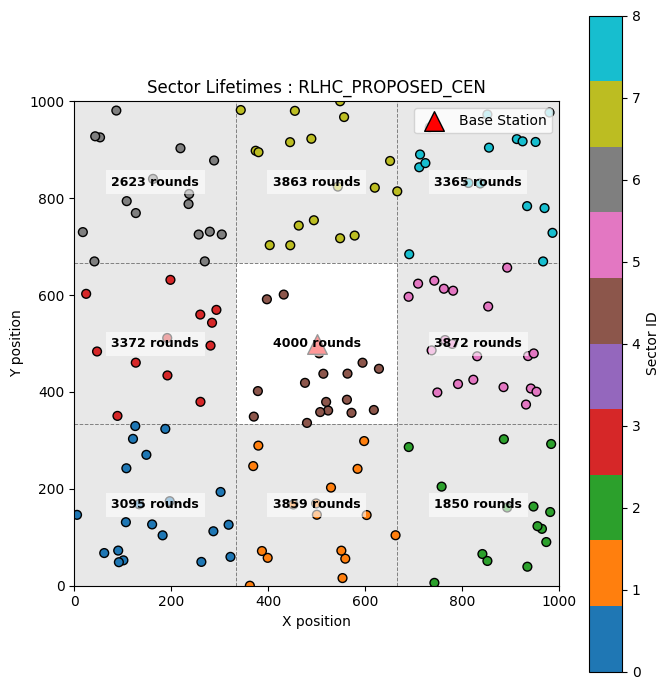

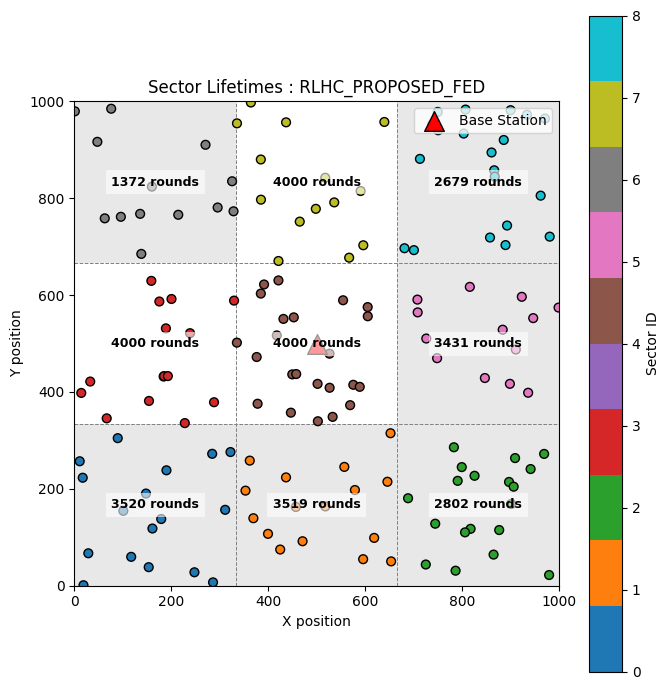

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

for idx, row in sector_life_table.iterrows():
    method_name = row["Method"]
    res = results[method_name]

    nodes_pos = np.array(res["nodes_pos"])
    sector_ids = np.array(res["sector_ids"])

    # get sector lifetimes from sector_life_table
    row = sector_life_table[sector_life_table["Method"] == method_name].iloc[0]
    sector_cols = [c for c in sector_life_table.columns if c.startswith("Sector")]
    sector_lifetimes = row[sector_cols].values.astype(float)

    # dimensions
    cell_w = AREA_SIZE / SECTOR_COLS
    cell_h = AREA_SIZE / SECTOR_ROWS

    plt.figure(figsize=(7, 7))
    ax = plt.gca()

    # -----------------------------
    # Shade sectors that died before last round
    # -----------------------------
    sector_index = 0
    for r in range(SECTOR_ROWS):
        for c in range(SECTOR_COLS):
            lifetime = sector_lifetimes[sector_index]

            # if sector did NOT survive till last round, shade it grey
            if lifetime < ROUNDS:
                rect = Rectangle(
                    (c * cell_w, r * cell_h),  # bottom-left corner
                    cell_w,
                    cell_h,
                    facecolor="lightgrey",
                    alpha=0.5,
                    edgecolor="none",
                    zorder=0  # behind other elements
                )
                ax.add_patch(rect)

            sector_index += 1

    # -----------------------------
    # Scatter plot of nodes colored by sector
    # -----------------------------
    sc = plt.scatter(
        nodes_pos[:, 0],
        nodes_pos[:, 1],
        c=sector_ids,
        cmap="tab10",
        s=40,
        edgecolor="black",
        zorder=2
    )

    # -----------------------------
    # Base Station
    # -----------------------------
    if BS_MODE != "fixed":
        # Make sure BS_TRAJECTORY is a numpy array
        bs_traj = np.array(BS_TRAJECTORY)

        if BS_MODE == "mobile_circle":
            # Plot BS path as a line
            plt.plot(
                bs_traj[:, 0],
                bs_traj[:, 1],
                linestyle="-",
                color="red",
                linewidth=1.5,
                label="BS path",
                zorder=3
            )

        if BS_MODE == "mobile_random":
            # Plot BS path as a line
            plt.plot(
                bs_traj[:, 0],
                bs_traj[:, 1],
                linestyle="--",
                color="red",
                linewidth=0.2,
                label="BS path",
                zorder=2
            )

    else:
        # Fixed BS for
        base_station = BASE_STATION_FIXED
        plt.scatter(
            base_station[0], base_station[1],
            marker="^",
            s=200,
            color="red",
            edgecolor="black",
            label="Base Station",
            zorder=3
        )

    plt.colorbar(sc, label="Sector ID")

    # -----------------------------
    # Draw grid lines
    # -----------------------------
    for c in range(SECTOR_COLS + 1):
        x = c * cell_w
        plt.axvline(x=x, color="gray", linestyle="--", linewidth=0.7, zorder=1)

    for r in range(SECTOR_ROWS + 1):
        y = r * cell_h
        plt.axhline(y=y, color="gray", linestyle="--", linewidth=0.7, zorder=1)

    # -----------------------------
    # Annotate each sector with lifetime
    # -----------------------------
    sector_index = 0
    for r in range(SECTOR_ROWS):
        for c in range(SECTOR_COLS):
            x_center = c * cell_w + cell_w / 2
            y_center = r * cell_h + cell_h / 2

            lifetime = sector_lifetimes[sector_index]
            text = f"{lifetime:.0f} rounds"

            plt.text(
                x_center, y_center,
                text,
                ha="center", va="center",
                fontsize=9,
                fontweight="bold",
                color="black",
                bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
                zorder=4
            )

            sector_index += 1

    # -----------------------------
    # Styling
    # -----------------------------
    plt.xlim(0, AREA_SIZE)
    plt.ylim(0, AREA_SIZE)
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title(f"Sector Lifetimes : {method_name}")
    ax.set_aspect("equal", adjustable="box")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


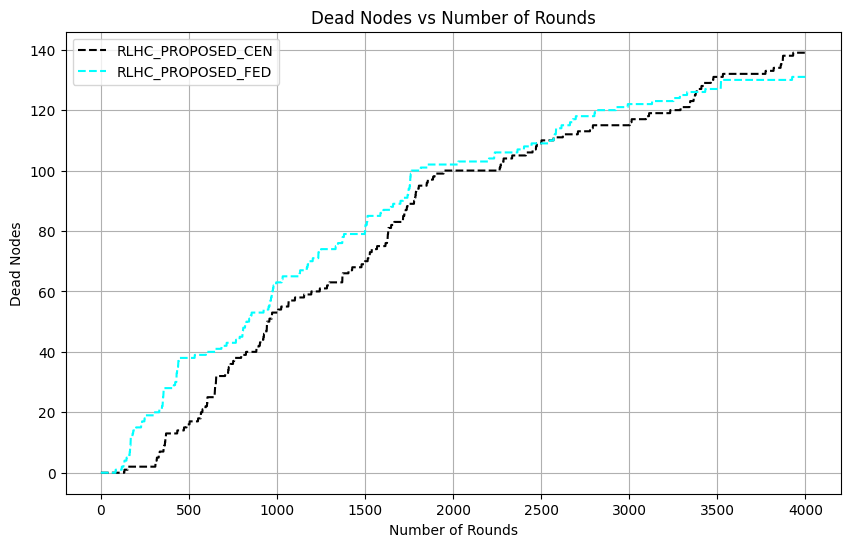

In [16]:
plt.figure(figsize=(10,6))
for method_name, res in results.items():
    rounds = range(1, res["last_dead_round"] + 1)
    dead_nodes = [N_NODES - a for a in res["alive_nodes_history"][:res["last_dead_round"]]]
    plt.plot(rounds, dead_nodes, label=method_name, linestyle="--", color=colors[list(METHODS.keys()).index(method_name)])
plt.xlabel("Number of Rounds")
plt.ylabel("Dead Nodes")
plt.title("Dead Nodes vs Number of Rounds")
plt.legend()
plt.grid(True)
plt.show()

### Plot 2: Alive Nodes vs Number of Rounds

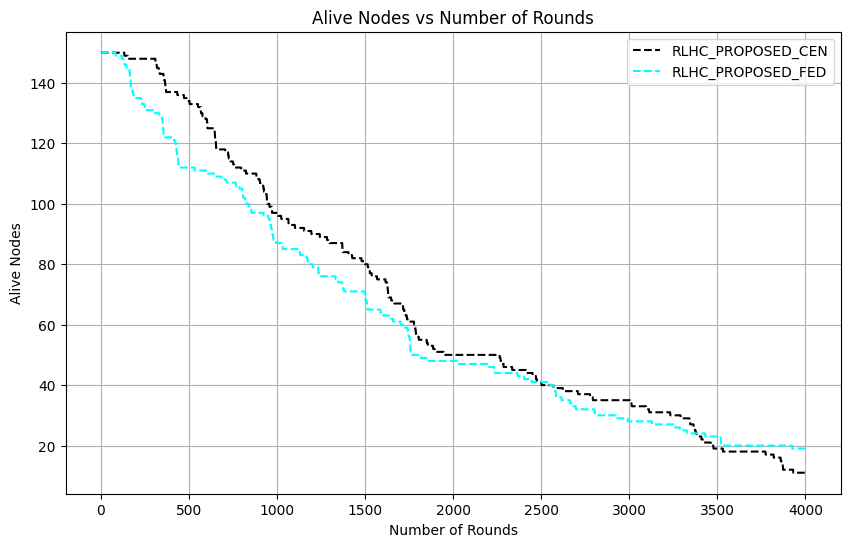

In [17]:
plt.figure(figsize=(10,6))
for method_name, res in results.items():
    rounds = range(1, res["last_dead_round"] + 1)
    alive_nodes = res["alive_nodes_history"][:res["last_dead_round"]]
    plt.plot(rounds, alive_nodes, label=method_name, linestyle="--", color=colors[list(METHODS.keys()).index(method_name)])
plt.xlabel("Number of Rounds")
plt.ylabel("Alive Nodes")
plt.title("Alive Nodes vs Number of Rounds")
plt.legend()
plt.grid(True)
plt.show()

### Plot 3: Cumulative Throughput vs Number of Rounds

RLHC_PROPOSED_CEN - Final cumulative throughput: 265705
RLHC_PROPOSED_FED - Final cumulative throughput: 245860


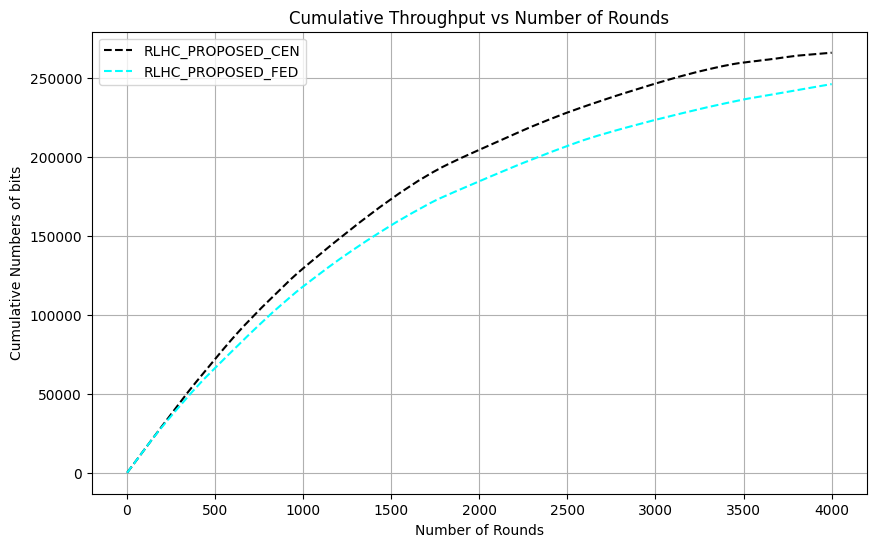

In [18]:
plt.figure(figsize=(10,6))
for method_name, res in results.items():
    rounds = range(1, res["last_dead_round"] + 1)
    cumulative_throughput = np.cumsum(res["throughput_history"][:res["last_dead_round"]])
    plt.plot(rounds, cumulative_throughput, label=method_name, linestyle="--", color=colors[list(METHODS.keys()).index(method_name)])
    # Print only final cumulative throughput
    print(f"{method_name} - Final cumulative throughput: {cumulative_throughput[-1]}")

plt.xlabel("Number of Rounds")
plt.ylabel("Cumulative Numbers of bits")
plt.title("Cumulative Throughput vs Number of Rounds")
plt.legend()
plt.grid(True)
plt.show()

### Plot 4: Total Energy Consumed vs Number of Rounds

RLHC_PROPOSED_CEN - Final energy consumed: 292.46607530449165
RLHC_PROPOSED_FED - Final energy consumed: 284.8485816845775


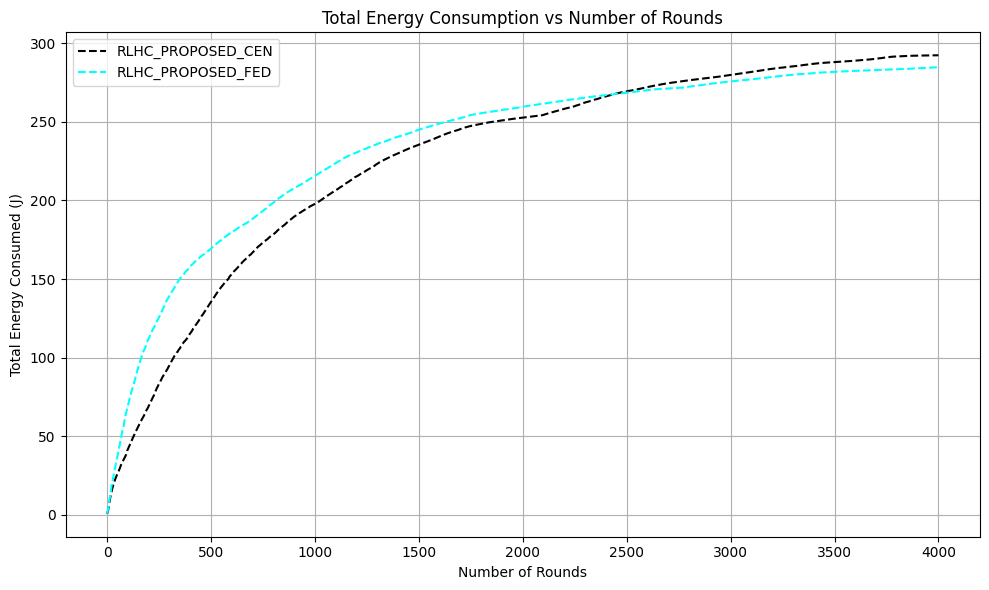

In [19]:
plt.figure(figsize=(10, 6))

for i, (method_name, res) in enumerate(results.items()):
    # total_energy_history[r] must be: sum of remaining energy of ALL nodes at round r
    total_E = np.array(res["total_energy_history"][:res["last_dead_round"]])

    initial_total_energy = N_NODES * INIT_ENERGY  # sum of all initial energies

    # Total energy consumed by all nodes up to each round
    total_energy_consumed = initial_total_energy - total_E
    
    rounds = np.arange(1, len(total_energy_consumed) + 1)
    plt.plot(
        rounds,
        total_energy_consumed,
        label=method_name,
        linestyle="--",
        color=colors[i],
    )
    print(f"{method_name} - Final energy consumed: {total_energy_consumed[-1]}")
plt.xlabel("Number of Rounds")
plt.ylabel("Total Energy Consumed (J)")
plt.title("Total Energy Consumption vs Number of Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Plot 5: Total PDR (%) Comparison

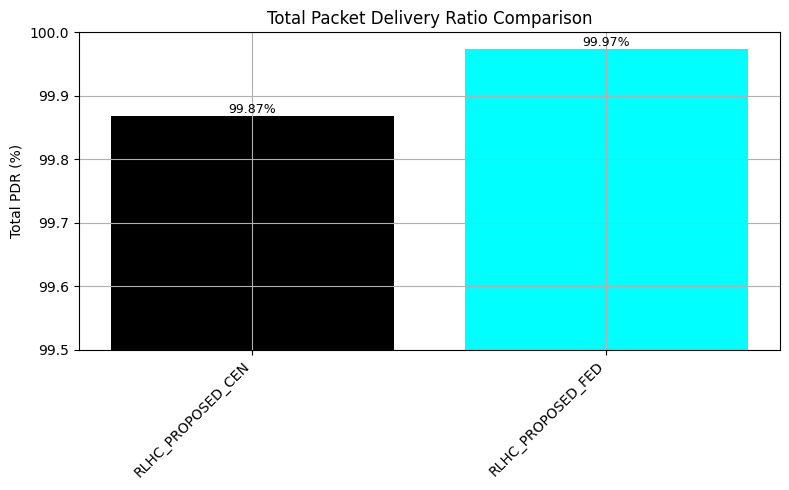

In [20]:
import matplotlib.pyplot as plt
import numpy as np

total_pdr = {method_name: np.mean(res["pdr_percent_history"][:res["last_dead_round"]])
             for method_name, res in results.items()}

ymin = 99.5
ymax = 100
plt.figure(figsize=(8,5))
bars = plt.bar(total_pdr.keys(), total_pdr.values(), color=colors[:len(total_pdr)])
plt.ylim(ymin, ymax)
plt.ylabel("Total PDR (%)")
plt.title("Total Packet Delivery Ratio Comparison")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Add value labels on top of each bar
for bar, val in zip(bars, total_pdr.values()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (ymax - ymin)*0.00,
             f"{val:.2f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



## 9. Results Summary

### Node Death Summary Table

In [21]:
death_table = pd.DataFrame({
    "Method": list(results.keys()),
    "First Node Death": [res["first_dead_round"] for res in results.values()],
    "Half Nodes Death": [res["half_dead_round"] for res in results.values()],
    "Last Node Death": [res["last_dead_round"] for res in results.values()]
})

# Stable region length (rounds 1 to FND-1; if FND is None, use total ROUNDS)
stable_region = []
unstable_region = []

for method_name, res in results.items():
    fnd = res["first_dead_round"]
    lnd = res["last_dead_round"]

    # If FND not reached, stable region = total simulated rounds
    if fnd is None:
        stable_len = ROUNDS
    else:
        stable_len = max(0, fnd - 1)

    # Unstable region = from FND to LND
    if fnd is None or lnd is None:
        unstable_len = 0
    else:
        unstable_len = max(0, lnd - fnd + 1)

    stable_region.append(stable_len)
    unstable_region.append(unstable_len)

death_table["Stable Region (rounds)"] = stable_region
death_table["Unstable Region (rounds)"] = unstable_region

print("\nNode Death & Stability Summary Table:")
display(death_table)



Node Death & Stability Summary Table:


,Method,First Node Death,Half Nodes Death,Last Node Death,Stable Region (rounds),Unstable Region (rounds)
0,RLHC_PROPOSED_CEN,135,1569,4000,134,3866
1,RLHC_PROPOSED_FED,85,1334,4000,84,3916


In [22]:
def plot_routing_single_round(method_name, nodes_pos, sector_ids, area_size, sector_rows, sector_cols, round_no):
    info = GLOBAL_ROUTING_INFO.get(method_name, {})

    pos_dict = info.get("nodes_pos", {})
    chs_dict = info.get("chs", {})
    clusters_dict = info.get("clusters", {})
    links_dict = info.get("links", {})

    nodes_pos_static = np.array(nodes_pos, dtype=float)
    nodes_pos_arr = np.array(pos_dict.get(round_no, nodes_pos_static), dtype=float)

    chs = chs_dict.get(round_no, [])
    clusters = clusters_dict.get(round_no, [])
    links = links_dict.get(round_no, [])

    fig, ax = plt.subplots(figsize=(7, 7))

    # -----------------------------
    # Sector grid
    # -----------------------------
    cell_w = area_size / sector_cols
    cell_h = area_size / sector_rows
    for r in range(sector_rows):
        for c in range(sector_cols):
            ax.add_patch(
                plt.Rectangle(
                    (c * cell_w, r * cell_h),
                    cell_w,
                    cell_h,
                    fill=False,
                    edgecolor="lightgray",
                    linewidth=0.7,
                    zorder=0
                )
            )

    # -----------------------------
    # Nodes
    # -----------------------------
    ax.scatter(
        nodes_pos_arr[:, 0],
        nodes_pos_arr[:, 1],
        c=sector_ids,
        cmap="tab10",
        s=40,
        edgecolor="black",
        zorder=2,
        label="Nodes"
    )

    # -----------------------------
    # Cluster Heads
    # -----------------------------
    if chs:
        ch_idx = np.array(chs, dtype=int)
        ch_pos = nodes_pos_arr[ch_idx]
        ax.scatter(
            ch_pos[:, 0],
            ch_pos[:, 1],
            s=120,
            marker="o",
            color="black",
            edgecolor="red",
            linewidth=1.2,
            zorder=4,
            label="CHs"
        )

    # -----------------------------
    # Base Station
    # -----------------------------
    bx, by = get_bs_position(round_no)
    ax.scatter(
        bx, by,
        s=230,
        marker="*",
        color="red",
        edgecolor="black",
        linewidth=1.2,
        zorder=5,
        label="BS"
    )

    # -----------------------------
    # Intra-cluster links
    # -----------------------------
    for cidx, cluster_nodes in enumerate(clusters):
        if not cluster_nodes or cidx >= len(chs):
            continue

        ch_node = int(chs[cidx])
        cx, cy = nodes_pos_arr[ch_node]

        for node in cluster_nodes:
            node = int(node)
            if node == ch_node:
                continue

            nx, ny = nodes_pos_arr[node]
            ax.plot(
                [nx, cx], [ny, cy],
                color="lightgray",
                linewidth=0.6,
                linestyle="--",
                alpha=0.9,
                zorder=1
            )

    # -----------------------------
    # Routing links
    # -----------------------------
    ch_set = set(int(x) for x in chs)

    for src, dst in links:
        src = int(src)
        x1, y1 = nodes_pos_arr[src]

        if int(dst) == -1:
            x2, y2 = bx, by
            color = "green"
            z = 3
        else:
            dst = int(dst)
            x2, y2 = nodes_pos_arr[dst]
            color = "red" if src in ch_set and dst in ch_set else "blue"
            z = 3 if color == "red" else 2

        ax.plot(
            [x1, x2], [y1, y2],
            color=color,
            linewidth=2.0 if color in ("red", "green") else 1,
            linestyle="-" if color in ("red", "green") else "--",
            alpha=0.9,
            zorder=z
        )

    # -----------------------------
    # Axis & legend
    # -----------------------------
    ax.set_xlim(0, area_size)
    ax.set_ylim(0, area_size)
    ax.set_aspect("equal")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(f"{method_name} | Routing & Clusters | Round {round_no}", fontweight="bold")

    ax.legend(loc="upper right")
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)

    plt.tight_layout()
    plt.show()


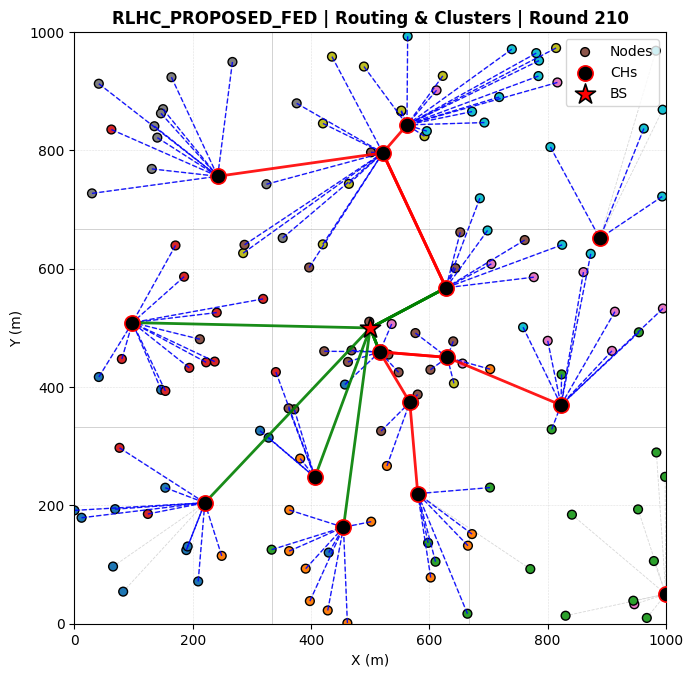

In [23]:
round_to_show = 210
method_name = M_RLHC_FED

plot_routing_single_round(
    method_name=method_name,
    nodes_pos=nodes_pos,
    sector_ids=sector_ids,
    area_size=AREA_SIZE,
    sector_rows=SECTOR_ROWS,
    sector_cols=SECTOR_COLS,
    round_no=round_to_show
)


In [24]:
def animate_routing_all_rounds(
    method_name,
    nodes_pos,
    sector_ids,
    area_size,
    sector_rows,
    sector_cols,
    rounds,
    interval=300  # ms between frames
):
    """
    Animate routing and clusters across all rounds for a given method
    using GLOBAL_ROUTING_INFO.

    Requires (recommended):
      GLOBAL_ROUTING_INFO[method_name]["nodes_pos"][rnd] = (N,2) positions per round
    Falls back to the passed `nodes_pos` if per-round positions are missing.
    """
    info = GLOBAL_ROUTING_INFO.get(method_name, {})

    # round -> (N,2) positions
    pos_dict = info.get("nodes_pos", {})
    nodes_pos_static = np.array(nodes_pos, dtype=float)  # fallback if pos_dict missing/empty

    chs_dict = info.get("chs", {})
    clusters_dict = info.get("clusters", {})
    links_dict = info.get("links", {})

    # initial draw positions (round 1 if exists)
    nodes_pos_arr0 = np.array(pos_dict.get(1, nodes_pos_static), dtype=float)

    fig, ax = plt.subplots(figsize=(7, 7))

    # -----------------------------
    # 1) Draw sector grid (static)
    # -----------------------------
    cell_w = area_size / sector_cols
    cell_h = area_size / sector_rows
    for r in range(sector_rows):
        for c in range(sector_cols):
            x0 = c * cell_w
            y0 = r * cell_h
            ax.add_patch(
                plt.Rectangle(
                    (x0, y0),
                    cell_w,
                    cell_h,
                    fill=False,
                    edgecolor="lightgray",
                    linewidth=0.7,
                    zorder=0
                )
            )

    # -----------------------------
    # 2) Node scatter (UPDATED per frame)
    # -----------------------------
    node_scatter = ax.scatter(
        nodes_pos_arr0[:, 0],
        nodes_pos_arr0[:, 1],
        c=sector_ids,
        cmap="tab10",
        s=40,
        edgecolor="black",
        zorder=2,
        label="Nodes"
    )

    # -----------------------------
    # 3) CH markers (updated per frame)
    # -----------------------------
    ch_scatter = ax.scatter(
        [], [],  # will be updated
        s=120,
        marker="o",
        color="black",
        edgecolor="red",
        linewidth=1.2,
        zorder=4,
        label="CHs"
    )

    # -----------------------------
    # 4) BS marker (updated per frame)
    # -----------------------------
    bs_scatter = ax.scatter(
        [], [],
        s=230,
        marker="*",
        color="red",
        edgecolor="black",
        linewidth=1.2,
        zorder=4,
        label="BS"
    )

    intra_lines = []   # member -> CH (light gray)
    route_lines = []   # routing links (colored)

    # Setup axes
    ax.set_xlim(0, area_size)
    ax.set_ylim(0, area_size)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    title_text = ax.set_title("")

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")

    # -----------------------------
    # Update functions
    # -----------------------------
    def init():
        return node_scatter, ch_scatter, bs_scatter, title_text

    def update(frame_idx):
        rnd = frame_idx + 1  # assuming rounds start at 1
        if rnd > rounds:
            rnd = rounds

        # --- IMPORTANT: per-round positions for THIS frame ---
        nodes_pos_arr = np.array(pos_dict.get(rnd, nodes_pos_static), dtype=float)
        node_scatter.set_offsets(nodes_pos_arr)

        # Get data for this round
        chs = chs_dict.get(rnd, [])
        clusters = clusters_dict.get(rnd, [])
        links = links_dict.get(rnd, [])

        # Update title
        title_text.set_text(f"{method_name} | Routing & Clusters | Round {rnd}")
        title_text.set_fontweight("bold")

        # Update CH scatter (guard for empty)
        if len(chs) > 0:
            ch_idx = np.array(chs, dtype=int)
            ch_pos = nodes_pos_arr[ch_idx]
            ch_scatter.set_offsets(ch_pos)
        else:
            ch_scatter.set_offsets(np.empty((0, 2)))

        # Update BS position
        bx, by = get_bs_position(rnd)
        bs_scatter.set_offsets(np.array([[bx, by]]))

        # Clear old lines
        for ln in intra_lines:
            ln.remove()
        intra_lines.clear()

        for ln in route_lines:
            ln.remove()
        route_lines.clear()

        # Draw member -> CH (from clusters & chs) in light gray
        for cidx, cluster_nodes in enumerate(clusters):
            if not cluster_nodes:
                continue
            if cidx >= len(chs):
                continue

            ch_node = int(chs[cidx])
            if ch_node < 0 or ch_node >= len(nodes_pos_arr):
                continue

            cx, cy = nodes_pos_arr[ch_node]

            for node in cluster_nodes:
                node = int(node)
                if node == ch_node:
                    continue
                if node < 0 or node >= len(nodes_pos_arr):
                    continue

                nx, ny = nodes_pos_arr[node]
                ln, = ax.plot(
                    [nx, cx],
                    [ny, cy],
                    color="lightgray",
                    linewidth=0.6,
                    linestyle="--",
                    alpha=0.9,
                    zorder=1
                )
                intra_lines.append(ln)

        # Draw routing links
        ch_set = set(int(x) for x in chs)

        for (src, dst) in links:
            src = int(src)
            if src < 0 or src >= len(nodes_pos_arr):
                continue

            x1, y1 = nodes_pos_arr[src]

            if int(dst) == -1:
                # CH -> BS
                x2, y2 = bx, by
                color = "green"
                z = 3.0
            else:
                dst = int(dst)
                if dst < 0 or dst >= len(nodes_pos_arr):
                    continue

                x2, y2 = nodes_pos_arr[dst]

                if src in ch_set and dst in ch_set:
                    color = "red"   # CH -> CH
                    z = 3.0
                else:
                    color = "blue"  # default
                    z = 2

            ln, = ax.plot(
                [x1, x2],
                [y1, y2],
                color=color,
                linewidth=2.0 if color in ("red", "green") else 1,
                linestyle="-" if color in ("red", "green") else "--",
                alpha=0.9,
                zorder=z
            )
            route_lines.append(ln)

        return node_scatter, ch_scatter, bs_scatter, title_text

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=rounds,
        init_func=init,
        interval=interval,
        blit=False,
        repeat=True
    )

    plt.tight_layout()
    return ani


In [25]:
# import matplotlib as mpl
# mpl.rcParams['animation.embed_limit'] = 900  # in MB
# interval = 400
# ani = animate_routing_all_rounds(
#     method_name=M_RLHC_FED,
#     nodes_pos=nodes_pos,
#     sector_ids=sector_ids,
#     area_size=AREA_SIZE,
#     sector_rows=SECTOR_ROWS,
#     sector_cols=SECTOR_COLS,
#     rounds=ROUNDS,
#     interval=interval
# )

# HTML(ani.to_jshtml())
# # gif_path = "routing_RLHC_PROPOSED.gif"
# # ani.save(gif_path, writer="pillow", fps=1000 / interval)  # fps from your interval (300 ms)
# # print("Saved GIF to:", gif_path)

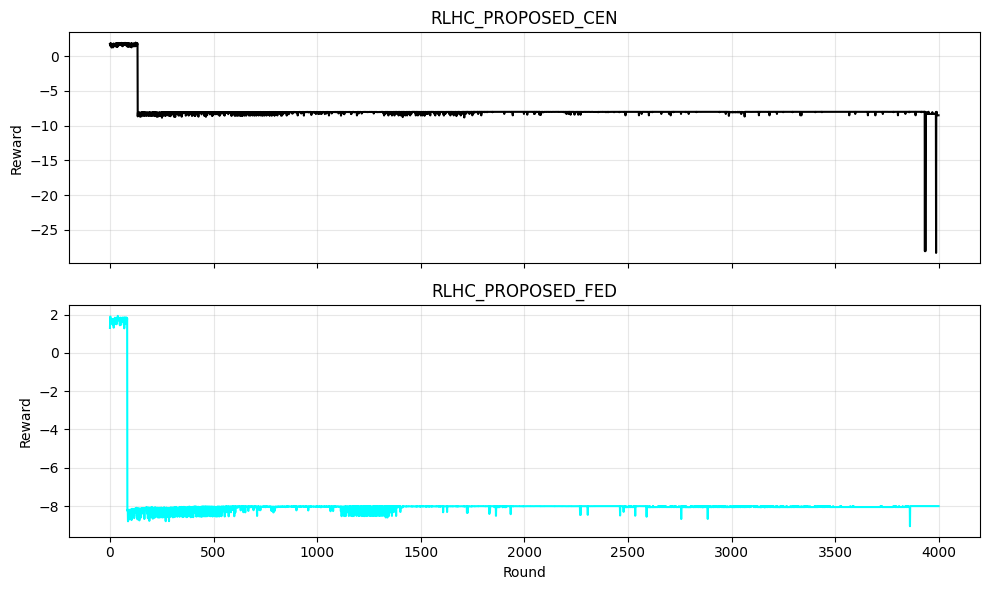

In [26]:
import matplotlib.pyplot as plt

methods = ["RLHC_PROPOSED_CEN", "RLHC_PROPOSED_FED"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

for ax, m in zip(axes, methods):
    r = results[m]["reward_history"]
    ax.plot(r, color="black" if "CEN" in m else "cyan")
    ax.set_title(m)
    ax.set_ylabel("Reward")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Round")

plt.tight_layout()
plt.show()


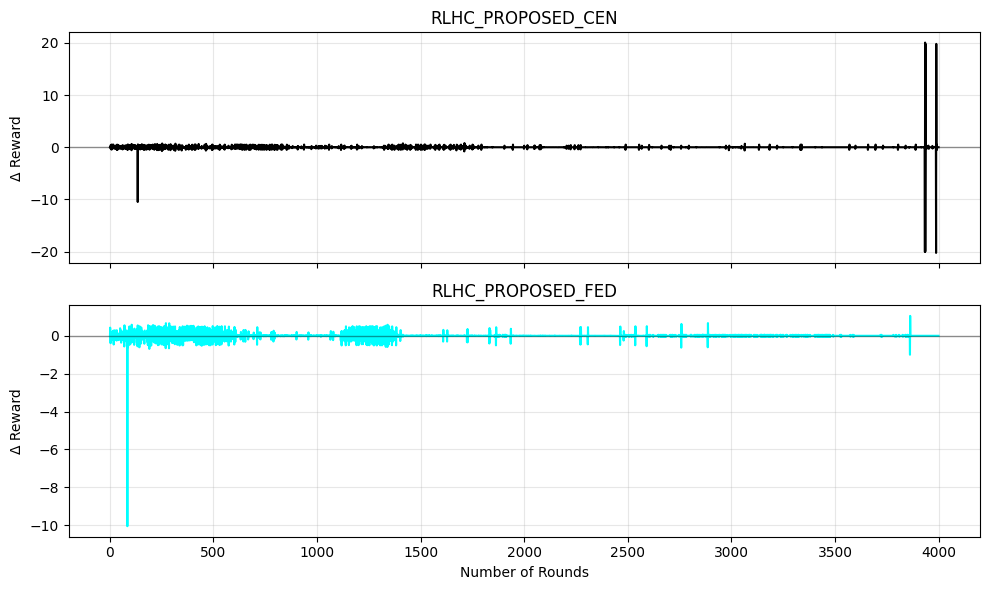

In [27]:
import numpy as np
import matplotlib.pyplot as plt

methods = ["RLHC_PROPOSED_CEN", "RLHC_PROPOSED_FED"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

for ax, m in zip(axes, methods):
    rewards = np.array(results[m]["reward_history"], dtype=float)
    rounds = np.arange(1, len(rewards) + 1)

    diff_reward = np.diff(rewards, prepend=rewards[0])  # first becomes 0

    ax.plot(rounds, diff_reward, color="black" if "CEN" in m else "cyan")
    ax.set_title(m)
    ax.set_ylabel("Δ Reward")
    ax.axhline(0, color="black", linewidth=1, alpha=0.4)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Number of Rounds")

plt.tight_layout()
plt.show()
